# data reading



In [1]:
# pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
# from skopt.space import Real, Integer, Categorical
# from skopt.utils import use_named_args
from torch.optim import Adam
# from skopt import gp_minimize
from scipy.signal import argrelextrema
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from scipy.stats import hmean
from itertools import product
from tqdm import tqdm
import random
from datetime import datetime, timedelta
from sklearn.model_selection import ParameterGrid
import matplotlib.dates as mdates
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import re
import os
import csv

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 指定文件路径
file_path = '/content/drive/My Drive/project/input_vectors_with_date.csv'

# 读取 CSV 文件到 DataFrame
df = pd.read_csv(file_path)

# 将 date 列转换为日期时间类型
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'Date'}, inplace=True)
# 打印前几行数据以检查
print(df.head())

# 打印数据类型以检查转换结果
print(df.dtypes)


        Date  1.0  2.0  5.0  10.0  11.0  12.0  13.0        14.0        15.0  \
0 2004-09-01  0.0  0.0  0.0   0.0   0.0   0.0   0.0  238.928789  238.985675   
1 2004-09-02  0.0  0.0  0.0   0.0   0.0   0.0   0.0  159.285859  159.323784   
2 2004-09-03  0.0  0.0  0.0   0.0   0.0   0.0   0.0  130.324794  130.355823   
3 2004-09-04  0.0  0.0  0.0   0.0   0.0   0.0   0.0  114.685819  114.713124   
4 2004-09-05  0.0  0.0  0.0   0.0   0.0   0.0   0.0  104.640346  104.665259   

   ...  22471.0    22472.0     22473.0     22474.0     22475.0  22476.0  \
0  ...      0.0    0.00000    0.000000    0.000000  925.625066      0.0   
1  ...      0.0    0.00000    0.000000    0.000000  617.083377      0.0   
2  ...      0.0    0.00000    0.000000  157.998531  504.886399      0.0   
3  ...      0.0    0.00000    0.000000  139.038707  444.300031      0.0   
4  ...      0.0  147.35311  264.321363  126.860134  531.164771      0.0   

      22540.0  22543.0  22547.0     22548.0  
0    0.000000      0.0      

In [4]:
file_path = '/content/drive/My Drive/project/interpolated_ili.csv'

# 读取 CSV 文件
interpolated_ili = pd.read_csv(file_path)
interpolated_ili['Date'] = pd.to_datetime(interpolated_ili['Date'])
interpolated_ili.set_index('Date', inplace=True)
# 显示前几行数据
print(interpolated_ili.head())

              ILIRate
Date                 
2003-12-29  12.472557
2003-12-30  12.771271
2003-12-31  13.069986
2004-01-01  13.368700
2004-01-02  13.667414


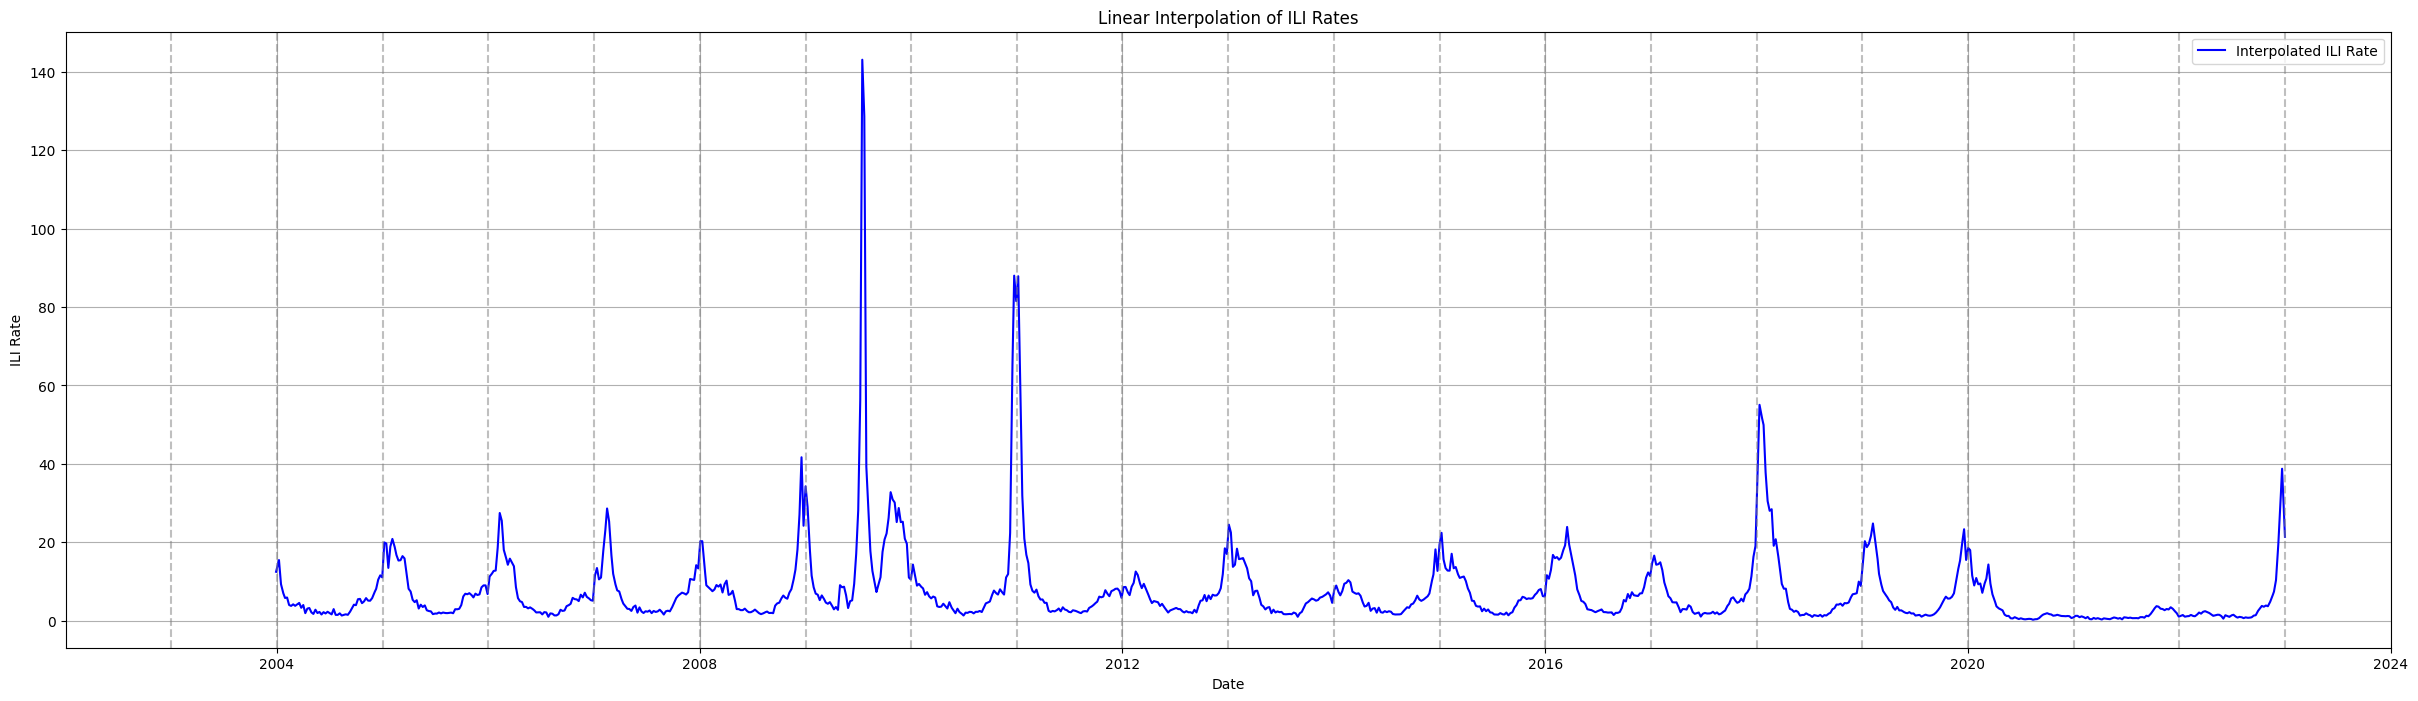

In [5]:
plt.figure(figsize=(30, 8))
plt.plot(interpolated_ili.index, interpolated_ili['ILIRate'], label='Interpolated ILI Rate', color='blue')

years = interpolated_ili.index.year.unique()
year_start_dates = [pd.Timestamp(str(year) + '-01-01') for year in years]

for date in year_start_dates:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)

plt.legend()
plt.xlabel('Date')
plt.ylabel('ILI Rate')
plt.title('Linear Interpolation of ILI Rates')
plt.grid(True)

plt.show()

# onset/offset threshold

In [ ]:
start_date = '2008-09-01'
end_date = '2013-08-31'
mask = (interpolated_ili.index >= start_date) & (interpolated_ili.index <= end_date)
filtered_data = interpolated_ili.loc[mask]

# 计算平均值和标准差
mean_ilirate = filtered_data['ILIRate'].mean()
std_ilirate = filtered_data['ILIRate'].std()

mean_ilirate, std_ilirate

(10.67229513378188, 16.15435895569972)

In [ ]:
start_date = '2013-09-01'
end_date = '2016-08-31'
mask = (interpolated_ili.index >= start_date) & (interpolated_ili.index <= end_date)
filtered_data = interpolated_ili.loc[mask]

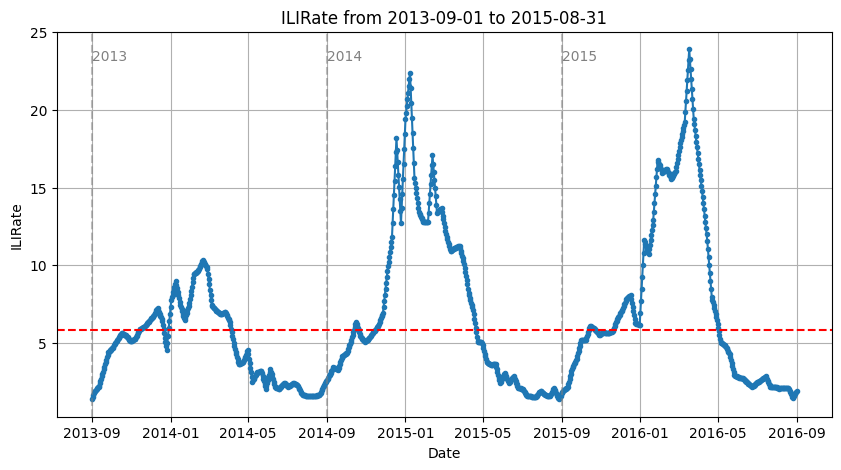

In [ ]:
set_threshold = mean_ilirate - 0.3 * std_ilirate

plt.figure(figsize=(10, 5))
plt.plot(filtered_data.index, filtered_data['ILIRate'], marker='.', linestyle='-')
plt.axhline(y=set_threshold, color='r', linestyle='--')

years = filtered_data.index.year.unique()
year_start_dates = [pd.Timestamp(str(year) + '-09-01') for year in years]

for date in year_start_dates:
    if date in filtered_data.index:
        plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5)
        plt.text(date, filtered_data['ILIRate'].max(), str(date.year), horizontalalignment='left', verticalalignment='top', color='gray')

plt.title('ILIRate from 2013-09-01 to 2015-08-31')
plt.xlabel('Date')
plt.ylabel('ILIRate')
plt.grid(True)
plt.show()

In [ ]:
start_year = 2013
end_year = 2016

# 存储每个流感季节的峰值
season_peaks = []

for year in range(start_year, end_year):
    season_start = pd.Timestamp(f'{year}-09-01')
    season_end = pd.Timestamp(f'{year+1}-08-31')

    # 筛选出当前流感季节的数据
    season_data = filtered_data[(filtered_data.index >= season_start) & (filtered_data.index <= season_end)]
    #print(season_data)
    peak_value = season_data['ILIRate'].max()
    peak_date = season_data['ILIRate'].idxmax()
    season_peaks.append((peak_date, peak_value))

# 打印每个流感季节的峰值
for peak_date, peak_value in season_peaks:
    print(f'Flu season peak on {peak_date.strftime("%Y-%m-%d")} with ILIRate of {peak_value}')

Flu season peak on 2014-02-20 with ILIRate of 10.3387
Flu season peak on 2015-01-08 with ILIRate of 22.4037
Flu season peak on 2016-03-17 with ILIRate of 23.9065


In [ ]:
cross_dates = []
previous_value = filtered_data['ILIRate'].iloc[0]

for current_date, current_value in filtered_data['ILIRate'].iloc[1:].items():
    if (previous_value >= set_threshold and current_value < set_threshold) or \
       (previous_value < set_threshold and current_value >= set_threshold):
        cross_dates.append(current_date)
    previous_value = current_value

# 打印被阈值相交的日期
print("Dates where ILIRate crosses the threshold:")
for date1, date2 in zip(cross_dates[::2], cross_dates[1::2]):
    print(date1, date2)


Dates where ILIRate crosses the threshold:
2013-11-14 00:00:00 2013-12-22 00:00:00
2013-12-29 00:00:00 2014-04-06 00:00:00
2014-10-13 00:00:00 2014-10-21 00:00:00
2014-11-15 00:00:00 2015-04-21 00:00:00
2015-10-13 00:00:00 2015-10-24 00:00:00
2015-11-20 00:00:00 2016-05-02 00:00:00


# 13 onset 60 + 14 peak 60 + 15 offset 60

## function

In [6]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_units1, n_units2, n_units3):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_units1)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(n_units1, n_units2)
        self.fc3 = nn.Linear(n_units2, n_units3)
        self.fc4 = nn.Linear(n_units3, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        return x

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def get_best_loss(self):
        return self.best_loss

    def get_best_model(self):
        return self.best_model

In [9]:
def calculate_correlations(X, y):
    correlations = []
    for i in range(X.shape[1]):
        # Check if the feature column has zero standard deviation
        if np.std(X[:, i]) == 0:
            continue

        # Check for missing values in the feature column and target column
        if np.any(np.isnan(X[:, i])) or np.any(np.isnan(y[:, 0])):
            continue

        # Calculate the correlation coefficient
        corr = np.corrcoef(X[:, i], y[:, 0])[0, 1]

        # Append the correlation if it's not NaN
        if not np.isnan(corr):
            correlations.append((i, corr))

    return correlations

def select_top_queries(correlations, top_n):
    sorted_correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
    top_indices = [index for index, _ in sorted_correlations[:top_n]]
    return top_indices

In [10]:

# param_grid = {
#     'n_units1': [50, 100],
#     'n_units2': [25, 50],
#     'n_units3': [25, 50],
#     'lr': [0.0001, 0.00001],
#     'batch_size': [14, 28, 56]
# }




param_grid = {
    'n_units1': [50, 100],
    'n_units2': [50, 25],
    'n_units3': [25, 50],
    'lr': [0.0001, 0.00001],
    'batch_size': [14, 28, 56]
}




In [11]:
def objective(n_units1, n_units2, n_units3, lr, batch_size, X_train, y_train, X_val, y_val, random_state):
    set_random_seed(random_state)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleNN(X_train.shape[1], n_units1, n_units2, n_units3).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    early_stopping = EarlyStopping(patience=5)  # 固定 patience

    # 创建DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(200):  # 固定 epochs
        set_random_seed(random_state)
        epoch_train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        with torch.no_grad():
            epoch_val_loss = 0.0
            for val_batch_X, val_batch_y in val_loader:
                val_batch_X, val_batch_y = val_batch_X.to(device), val_batch_y.to(device).view(-1, 1)
                val_outputs = model(val_batch_X)
                epoch_val_loss += criterion(val_outputs, val_batch_y).item()

            epoch_val_loss /= len(val_loader)
            val_losses.append(epoch_val_loss)

        # 只有在epoch >= 10时才开始检查early stopping
        if epoch >= 20:
            early_stopping(epoch_val_loss, model)
            if early_stopping.early_stop:
                # print(f"Early stopping at epoch {epoch}")
                break

    # 加载最优模型参数
    model.load_state_dict(early_stopping.get_best_model())

    return early_stopping.get_best_loss(), train_losses, val_losses, model, epoch


In [12]:
def grid_search(param_grid, X_train, y_train, X_val, y_val, random_state):
    best_loss = float('inf')
    best_params = None
    best_train_losses = []
    best_val_losses = []
    best_model = None
    best_epoch = None

    for params in ParameterGrid(param_grid):
        val_loss, train_losses, val_losses, model, epoch = objective(
            params['n_units1'], params['n_units2'], params['n_units3'], params['lr'], params['batch_size'], X_train, y_train, X_val, y_val, random_state)

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_model = model
            best_epoch = epoch

        # plt.figure(figsize=(12, 6))
        # plt.plot(train_losses, label='Train Loss')
        # plt.plot(val_losses, label='Validation Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title(f'Training and Validation Loss Over Epochs for params: {params}')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        # print(f"parameters: {params}")
        # print(f"validation loss: {val_loss}")
        # print(val_losses)

    print(f"Best parameters: {best_params}")
    print(f"Best validation loss: {best_loss}")
    return best_params, best_train_losses, best_val_losses, best_model, best_epoch, best_loss


In [13]:
def calculate_dates(test_start_str, test_end_str, train1_start_str, val_periods):
    test_start_date = datetime.strptime(test_start_str, '%Y-%m-%d')
    test_end_date = datetime.strptime(test_end_str, '%Y-%m-%d')
    train1_start_date = datetime.strptime(train1_start_str, '%Y-%m-%d')
    train1_end_date = test_start_date - timedelta(days=7)

    val_periods_dates = [(datetime.strptime(start, '%Y-%m-%d'), datetime.strptime(end, '%Y-%m-%d')) for start, end in val_periods]

    train0_periods = []
    current_start = train1_start_date

    for val_start, val_end in val_periods_dates:
        if current_start < val_start:
            train0_periods.append((current_start, val_start - timedelta(days=1)))
        current_start = val_end + timedelta(days=1)

    if current_start <= train1_end_date:
        train0_periods.append((current_start, train1_end_date))

    return {
        'train0': train0_periods,
        'train1': (train1_start_date, train1_end_date),
        'val': val_periods_dates,
        'test': (test_start_date, test_end_date)
    }


In [14]:
def is_continuous_seven_days(dates):
    return all((dates.iloc[i] - dates.iloc[i-1]).days == 1 for i in range(1, len(dates)))

# 准备训练数据和验证数据
def prepare_data(data, window_size=14):
    X = []
    y = []
    data = data.reset_index(drop=True)  # 重置索引
    for i in range(len(data) - window_size + 1):
        date_slice = data['Date'].iloc[i:i + window_size]
        if is_continuous_seven_days(date_slice):
            X.append(data.iloc[i:i + window_size].drop(columns=['Date', 'ILIRate']).values.flatten())
            y.append(data['ILIRate'].iloc[i + window_size - 1])
    return pd.DataFrame(X), pd.Series(y)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## forecasting




In [16]:
prediction_start_date = datetime.strptime('2018-09-01', '%Y-%m-%d')
prediction_end_date = datetime.strptime('2019-08-31', '%Y-%m-%d')
window_size = 14
forecasting_horizon = 14
interpolated_ili.index = interpolated_ili.index - pd.Timedelta(days=forecasting_horizon)

test_start_date = (prediction_start_date - timedelta(days=(window_size + forecasting_horizon - 1))).strftime('%Y-%m-%d')

test_end_date = (prediction_end_date - timedelta(days=forecasting_horizon)).strftime('%Y-%m-%d')

train1_start_str = '2008-09-01'

x_onset_dates = ["2016-05-08", "2017-01-12", "2017-10-02"]
x_onset_dates = [datetime.strptime(date, "%Y-%m-%d") for date in x_onset_dates]
val_start_dates = [date - timedelta(days=29) for date in x_onset_dates]
val_end_dates = [date + timedelta(days=30) for date in x_onset_dates]

val_periods = [(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')) for start_date, end_date in zip(val_start_dates, val_end_dates)]


In [17]:

dates = calculate_dates(test_start_date, test_end_date, train1_start_str, val_periods)

test_start, test_end = dates['test']
train1_start, train1_end = dates['train1']
val_periods_dates = dates['val']
train0_periods_dates = dates['train0']

test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)].reset_index(drop=True)
train1_data = df[(df['Date'] >= train1_start) & (df['Date'] <= train1_end)].reset_index(drop=True)
validation_data = pd.concat([df[(df['Date'] >= start) & (df['Date'] <= end)] for start, end in val_periods_dates], ignore_index=True).reset_index(drop=True)
train0_data = pd.concat([df[(df['Date'] >= start) & (df['Date'] <= end)] for start, end in train0_periods_dates], ignore_index=True).reset_index(drop=True)


y_train_1 = interpolated_ili[(interpolated_ili.index >= train1_start) & (interpolated_ili.index <= train1_end)]
y_test = interpolated_ili[(interpolated_ili.index >= test_start) & (interpolated_ili.index <= test_end)]

y_train0_periods_dates = [(start, end) for start, end in train0_periods_dates]
y_val_periods_dates = [(start, end) for start, end in val_periods_dates]

y_train_0 = pd.concat([interpolated_ili[(interpolated_ili.index >= start) & (interpolated_ili.index <= end)] for start, end in y_train0_periods_dates], ignore_index=True)
y_val = pd.concat([interpolated_ili[(interpolated_ili.index >= start) & (interpolated_ili.index <= end)] for start, end in y_val_periods_dates], ignore_index=True)

train1_data['ILIRate'] = y_train_1.reset_index(drop=True)
test_data['ILIRate'] = y_test.reset_index(drop=True)
train0_data['ILIRate'] = y_train_0.reset_index(drop=True)
validation_data['ILIRate'] = y_val.reset_index(drop=True)

for col in train1_data.columns:
    if train1_data[col].dtype == 'object':
        train1_data[col] = pd.to_numeric(train1_data[col], errors='coerce')


train_correlation_str = datetime.strptime('2013-09-01', '%Y-%m-%d')
train_correlation_end = datetime.strptime('2018-08-31', '%Y-%m-%d')
correlation_data = df[(df['Date'] >= train_correlation_str) & (df['Date'] <= train_correlation_end)].reset_index(drop=True)
y_correlation = interpolated_ili[(interpolated_ili.index >= train_correlation_str) & (interpolated_ili.index <= train_correlation_end)]
correlation_data['ILIRate'] = y_correlation.reset_index(drop=True)

for col in correlation_data.columns:
    if correlation_data[col].dtype == 'object':
        correlation_data[col] = pd.to_numeric(correlation_data[col], errors='coerce')

correlations_corr = correlation_data.drop(columns=['Date','ILIRate']).corrwith(correlation_data['ILIRate'])



N = [100, 200, 300, 400]



/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [18]:
def scale_data(top_N_query_ids_corr, test_data, train1_data, validation_data, train0_data):
    test_data_p = test_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]
    train1_data_p = train1_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]
    validation_data_p = validation_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]
    train0_data_p = train0_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]


    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train0_data_scaled = train0_data_p.copy()
    train0_data_scaled[list(top_N_query_ids_corr)] = feature_scaler.fit_transform(train0_data_p[list(top_N_query_ids_corr)])
    train0_data_scaled[['ILIRate']] = target_scaler.fit_transform(train0_data_p[['ILIRate']])

    validation_data_scaled = validation_data_p.copy()
    validation_data_scaled[list(top_N_query_ids_corr)] = feature_scaler.transform(validation_data_p[list(top_N_query_ids_corr)])
    validation_data_scaled[['ILIRate']] = target_scaler.transform(validation_data_p[['ILIRate']])

    test_data_scaled = test_data_p.copy()
    test_data_scaled[list(top_N_query_ids_corr)] = feature_scaler.transform(test_data_p[list(top_N_query_ids_corr)])
    test_data_scaled[['ILIRate']] = target_scaler.transform(test_data_p[['ILIRate']])
    return train0_data_scaled, validation_data_scaled, test_data_scaled, target_scaler

In [19]:
def train_evaluate_model(rs, param_grid, train0_X, train0_y, validation_X, validation_y, test_X, test_y, target_scaler):
    set_random_seed(rs)
    best_params, train_losses, val_losses, best_model, best_epoch, best_loss = grid_search(param_grid, train0_X, train0_y, validation_X, validation_y, rs)

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Best parameters: {best_params}")
    print(f"Number of epochs for best model: {best_epoch}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)
    criterion = nn.L1Loss()

    test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    best_model.eval()
    all_test_outputs = []
    all_y_test = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)
            test_outputs = best_model(batch_X)
            all_test_outputs.extend(test_outputs.cpu().numpy().flatten())
            all_y_test.extend(batch_y.cpu().numpy().flatten())

    y_test_df = pd.DataFrame(all_y_test, columns=['ILIRate'])
    y_pred_df = pd.DataFrame(all_test_outputs, columns=['ILIRate'])

    y_test_original_scale = target_scaler.inverse_transform(y_test_df)
    y_pred_original_scale = target_scaler.inverse_transform(y_pred_df)

    test_loss = criterion(torch.tensor(y_pred_original_scale, dtype=torch.float32), torch.tensor(y_test_original_scale, dtype=torch.float32)).item()
    correlation = np.corrcoef(y_pred_original_scale.flatten(), y_test_original_scale.flatten())[0, 1]

    print("Test loss: {:.3f}".format(test_loss))
    print("Test correlation: {:.3f}".format(correlation))

    return best_loss, test_loss, correlation, best_params, y_pred_original_scale.flatten(), best_epoch, y_test_original_scale.flatten()


In [20]:
def plot_results(rs, y_test_original_scale, best_predicted_values):
    dates = pd.date_range(start='2018-09-01', end='2019-08-31', freq='D')

    # 创建文件夹路径
    output_dir = "/content/drive/MyDrive/project/forecasting_14/18-19/plot/win14/6"

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(dates, y_test_original_scale.flatten(), label='True Values', marker='o', markersize=2, linestyle='-')
    ax.plot(dates, best_predicted_values, label='Predicted Values', marker='x', markersize=3, linestyle='-')

    ax.set_xlabel('Date')
    ax.set_ylabel('ILI Rate')
    ax.set_title('True vs Predicted Values')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_ylim(0, 60)
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True)

    plt.savefig(os.path.join(output_dir, f"18_19_6_fore_14_{rs}.pdf"))
    plt.show()

In [21]:
file_path = '/content/drive/MyDrive/project/forecasting_14/18-19/results_s6.csv'


fields = ['test_season', 'input_size', 'random_state', 'best_validation_loss', 'best_test_loss', 'best_test_correlation', 'best_parameters', 'query_numbers', 'number_of_epochs']

# 如果文件不存在，创建文件并写入字段名
if not os.path.isfile(file_path):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(fields)

In [22]:
random_seeds = [1024, 2048, 4096, 8192, 16384, 15510, 1854, 18296, 16652, 11085]

test_loss_all = []
test_correlation_all = []
all_predictions = []

with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    for rs in random_seeds:
        min_loss = 1000000
        tl = 0
        tcorr = 0
        params = {}
        quries_number = 0
        epoch_number = 0
        best_predicted_values = []
        for n in N:
            top_N_query_ids_corr = correlations_corr.abs().sort_values(ascending=False).head(n).index

            train0_data_scaled, validation_data_scaled, test_data_scaled, target_scaler = scale_data(top_N_query_ids_corr, test_data, train1_data, validation_data, train0_data)

            train0_X, train0_y = prepare_data(train0_data_scaled)
            validation_X, validation_y = prepare_data(validation_data_scaled)
            test_X, test_y = prepare_data(test_data_scaled)

            train0_y = train0_y.values.reshape(-1, 1)
            test_y = test_y.values.reshape(-1, 1)
            validation_y = validation_y.values.reshape(-1, 1)

            train0_X = train0_X.values
            test_X = test_X.values
            validation_X = validation_X.values

            val_loss, test_loss, correlation, best_params, y_pred, best_epoch, y_true = train_evaluate_model(rs, param_grid, train0_X, train0_y, validation_X, validation_y, test_X, test_y, target_scaler)

            if val_loss < min_loss:
                min_loss = val_loss
                tl = test_loss
                tcorr = correlation
                params = best_params
                best_predicted_values = y_pred
                quries_number = n
                epoch_number = best_epoch - 5

        test_loss_all.append(tl)
        test_correlation_all.append(tcorr)
        all_predictions.append(best_predicted_values)


        '''
        ['test_season', 'input_size', 'random_state', 'best_validation_loss',
        'best_test_loss', 'best_test_correlation', 'best_parameters', 'query_numbers', 'number_of_epochs']
        '''
        writer.writerow(['18-19', '14', rs, min_loss, tl, tcorr, str(params), quries_number, epoch_number])

        print(f"random state: {rs}")
        print("Best Test loss: {:.3f}".format(tl))
        print("Best Test correlation: {:.3f}".format(tcorr))
        print(f"Best parameters: {params}")
        print(f"Best validation loss: {min_loss}")
        print(f"query numbers: {quries_number}")
        print(f"Number of epochs for best model: {epoch_number}")
        plot_results(rs, y_true, best_predicted_values)
        print("...............................................................")


Output hidden; open in https://colab.research.google.com to view.

## Nowcasting

In [ ]:
test_start_str = '2018-08-19'
test_end_str = '2019-08-31'
train1_start_str = '2008-09-01'

x_onset_dates = ["2016-05-08", "2017-01-12", "2017-10-02"]
x_onset_dates = [datetime.strptime(date, "%Y-%m-%d") for date in x_onset_dates]
val_start_dates = [date - timedelta(days=29) - timedelta(days=14) for date in x_onset_dates]
val_end_dates = [date + timedelta(days=30) for date in x_onset_dates]

val_periods = [(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')) for start_date, end_date in zip(val_start_dates, val_end_dates)]

dates = calculate_dates(test_start_str, test_end_str, train1_start_str, val_periods)

test_start, test_end = dates['test']
train1_start, train1_end = dates['train1']
val_periods_dates = dates['val']
train0_periods_dates = dates['train0']

test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)].reset_index(drop=True)
train1_data = df[(df['Date'] >= train1_start) & (df['Date'] <= train1_end)].reset_index(drop=True)
validation_data = pd.concat([df[(df['Date'] >= start) & (df['Date'] <= end)] for start, end in val_periods_dates], ignore_index=True).reset_index(drop=True)
train0_data = pd.concat([df[(df['Date'] >= start) & (df['Date'] <= end)] for start, end in train0_periods_dates], ignore_index=True).reset_index(drop=True)


# 获取 y 值数据，并保留索引
y_train_1 = interpolated_ili[(interpolated_ili.index >= train1_start) & (interpolated_ili.index <= train1_end)]
y_test = interpolated_ili[(interpolated_ili.index >= test_start) & (interpolated_ili.index <= test_end)]

y_train0_periods_dates = [(start, end) for start, end in train0_periods_dates]
y_val_periods_dates = [(start, end) for start, end in val_periods_dates]

y_train_0 = pd.concat([interpolated_ili[(interpolated_ili.index >= start) & (interpolated_ili.index <= end)] for start, end in y_train0_periods_dates], ignore_index=True)
y_val = pd.concat([interpolated_ili[(interpolated_ili.index >= start) & (interpolated_ili.index <= end)] for start, end in y_val_periods_dates], ignore_index=True)

train1_data['ILIRate'] = y_train_1.reset_index(drop=True)
test_data['ILIRate'] = y_test.reset_index(drop=True)
train0_data['ILIRate'] = y_train_0.reset_index(drop=True)
validation_data['ILIRate'] = y_val.reset_index(drop=True)

for col in train1_data.columns:
    if train1_data[col].dtype == 'object':
        train1_data[col] = pd.to_numeric(train1_data[col], errors='coerce')



train_correlation_str = datetime.strptime('2013-09-01', '%Y-%m-%d')
train_correlation_end = datetime.strptime('2018-08-31', '%Y-%m-%d')
correlation_data = df[(df['Date'] >= train_correlation_str) & (df['Date'] <= train_correlation_end)].reset_index(drop=True)
y_correlation = interpolated_ili[(interpolated_ili.index >= train_correlation_str) & (interpolated_ili.index <= train_correlation_end)]
correlation_data['ILIRate'] = y_correlation.reset_index(drop=True)

for col in correlation_data.columns:
    if correlation_data[col].dtype == 'object':
        correlation_data[col] = pd.to_numeric(correlation_data[col], errors='coerce')

correlations_corr = correlation_data.drop(columns=['Date','ILIRate']).corrwith(correlation_data['ILIRate'])



# thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

# # 初始化结果字典
# N = {}

# # 对每个阈值进行处理
# for threshold in thresholds:
#     filtered_correlations = correlations_corr[correlations_corr > threshold]
#     count_above_threshold = filtered_correlations.count()
#     N[threshold] = count_above_threshold
# # 打印结果
# for threshold, results in N.items():
#     print(f"Number of correlations greater than {threshold} is {results}")

N = [100, 200, 300, 400]



/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
def scale_data(top_N_query_ids_corr, test_data, train1_data, validation_data, train0_data):
    test_data_p = test_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]
    train1_data_p = train1_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]
    validation_data_p = validation_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]
    train0_data_p = train0_data[['Date', 'ILIRate'] + list(top_N_query_ids_corr)]


    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    train0_data_scaled = train0_data_p.copy()
    train0_data_scaled[list(top_N_query_ids_corr)] = feature_scaler.fit_transform(train0_data_p[list(top_N_query_ids_corr)])
    train0_data_scaled[['ILIRate']] = target_scaler.fit_transform(train0_data_p[['ILIRate']])

    validation_data_scaled = validation_data_p.copy()
    validation_data_scaled[list(top_N_query_ids_corr)] = feature_scaler.transform(validation_data_p[list(top_N_query_ids_corr)])
    validation_data_scaled[['ILIRate']] = target_scaler.transform(validation_data_p[['ILIRate']])

    test_data_scaled = test_data_p.copy()
    test_data_scaled[list(top_N_query_ids_corr)] = feature_scaler.transform(test_data_p[list(top_N_query_ids_corr)])
    test_data_scaled[['ILIRate']] = target_scaler.transform(test_data_p[['ILIRate']])
    return train0_data_scaled, validation_data_scaled, test_data_scaled, target_scaler

In [ ]:
def train_evaluate_model(rs, param_grid, train0_X, train0_y, validation_X, validation_y, test_X, test_y, target_scaler):
    set_random_seed(rs)
    best_params, train_losses, val_losses, best_model, best_epoch, best_loss = grid_search(param_grid, train0_X, train0_y, validation_X, validation_y, rs)

    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Best parameters: {best_params}")
    print(f"Number of epochs for best model: {best_epoch}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)
    criterion = nn.L1Loss()

    test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    best_model.eval()
    all_test_outputs = []
    all_y_test = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)
            test_outputs = best_model(batch_X)
            all_test_outputs.extend(test_outputs.cpu().numpy().flatten())
            all_y_test.extend(batch_y.cpu().numpy().flatten())

    y_test_df = pd.DataFrame(all_y_test, columns=['ILIRate'])
    y_pred_df = pd.DataFrame(all_test_outputs, columns=['ILIRate'])

    y_test_original_scale = target_scaler.inverse_transform(y_test_df)
    y_pred_original_scale = target_scaler.inverse_transform(y_pred_df)

    test_loss = criterion(torch.tensor(y_pred_original_scale, dtype=torch.float32), torch.tensor(y_test_original_scale, dtype=torch.float32)).item()
    correlation = np.corrcoef(y_pred_original_scale.flatten(), y_test_original_scale.flatten())[0, 1]

    print("Test loss: {:.3f}".format(test_loss))
    print("Test correlation: {:.3f}".format(correlation))

    return best_loss, test_loss, correlation, best_params, y_pred_original_scale.flatten(), best_epoch, y_test_original_scale.flatten()


In [ ]:
def plot_results(rs, y_test_original_scale, best_predicted_values):
    dates = pd.date_range(start='2018-09-01', end='2019-08-31', freq='D')

    # 创建文件夹路径
    output_dir = "/content/drive/MyDrive/project/nowcasting_results/18-19/plot/win14/s6/"

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(dates, y_test_original_scale.flatten(), label='True Values', marker='o', markersize=2, linestyle='-')
    ax.plot(dates, best_predicted_values, label='Predicted Values', marker='x', markersize=3, linestyle='-')

    ax.set_xlabel('Date')
    ax.set_ylabel('ILI Rate')
    ax.set_title('True vs Predicted Values')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_ylim(0, 60)
    plt.xticks(rotation=45)
    ax.legend()
    ax.grid(True)

    plt.savefig(os.path.join(output_dir, f"18_19_6_now_{rs}.pdf"))
    plt.show()

In [ ]:
# 定义文件路径
file_path = '/content/drive/MyDrive/project/nowcasting_results/18-19/results_s6.csv'

fields = ['test_season', 'input_size', 'random_state', 'best_validation_loss', 'best_test_loss', 'best_test_correlation', 'best_parameters', 'query_numbers', 'number_of_epochs']

# 如果文件不存在，创建文件并写入字段名
if not os.path.isfile(file_path):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(fields)

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.00804626861853259


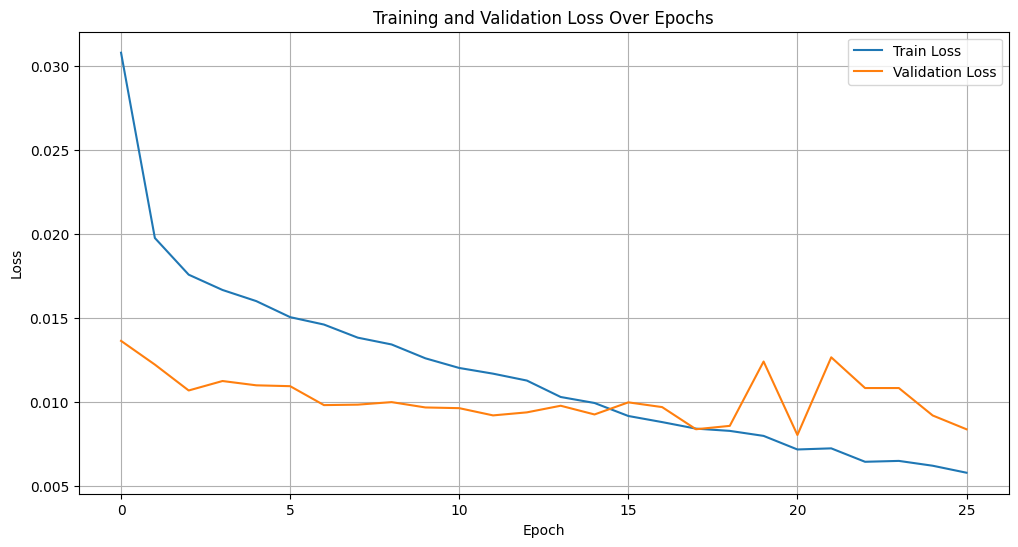

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 25
Test loss: 1.726
Test correlation: 0.928
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.005962217209993729


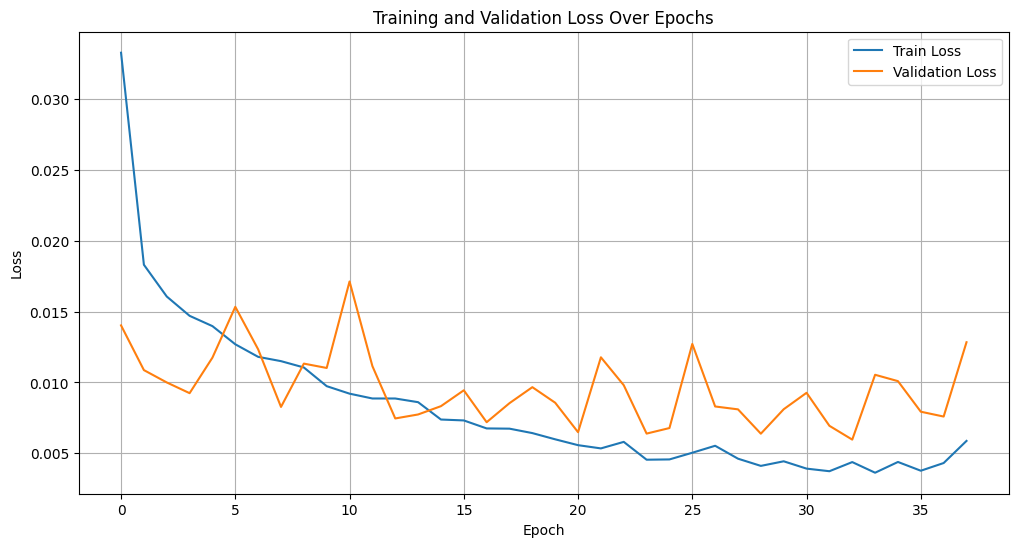

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 37
Test loss: 2.522
Test correlation: 0.914
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.0049965989892371


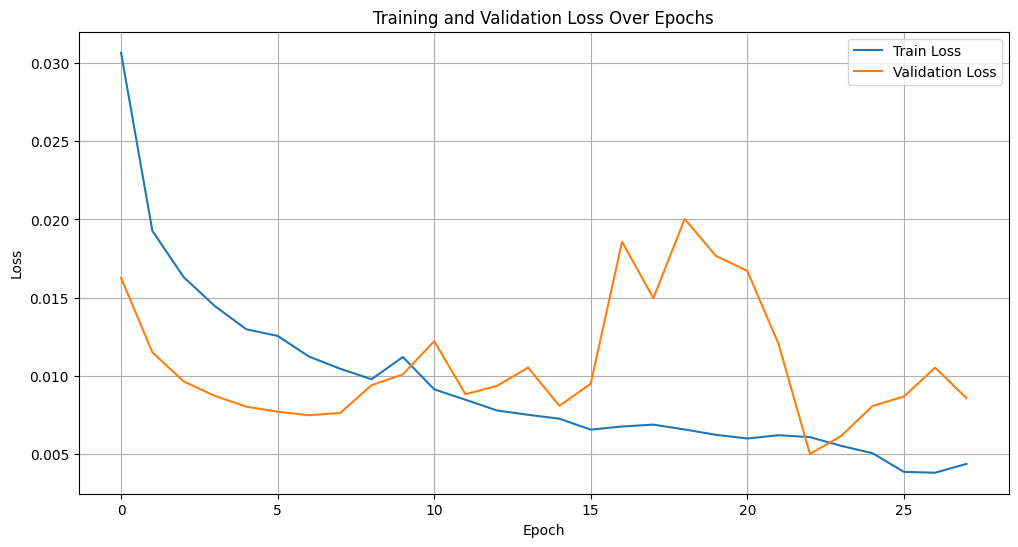

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 27
Test loss: 3.061
Test correlation: 0.925
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.004215391352772713


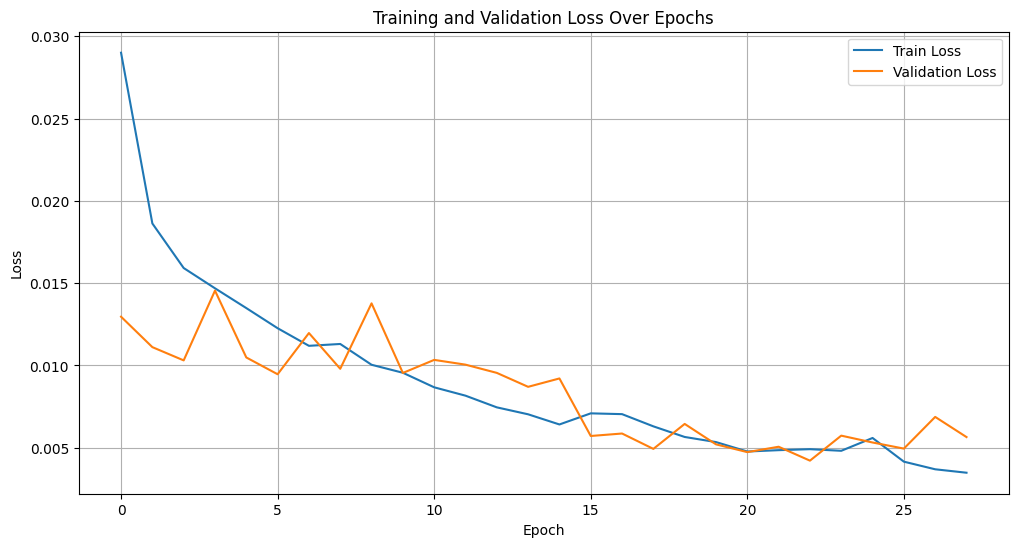

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 27
Test loss: 1.904
Test correlation: 0.941
random state: 1024
Best Test loss: 1.904
Best Test correlation: 0.941
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.004215391352772713
query numbers: 400
Number of epochs for best model: 22


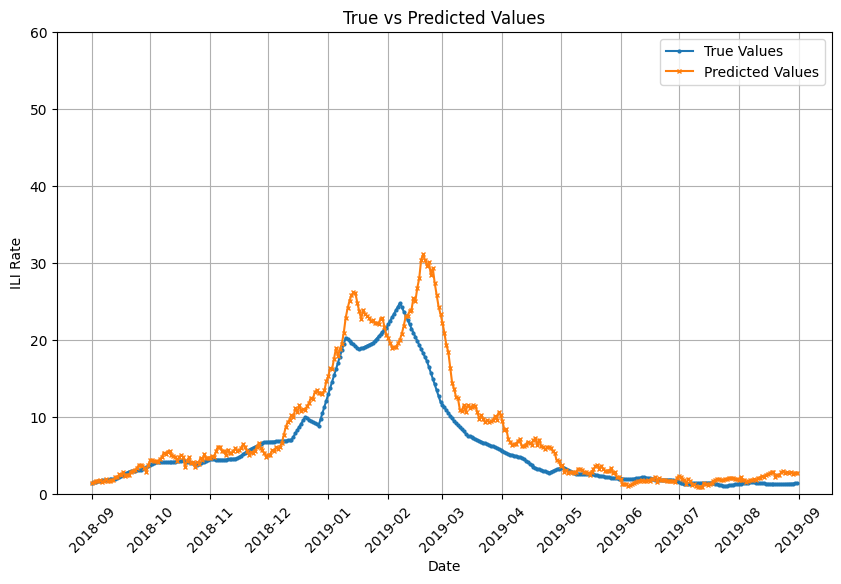

...............................................................
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.008619255519339017


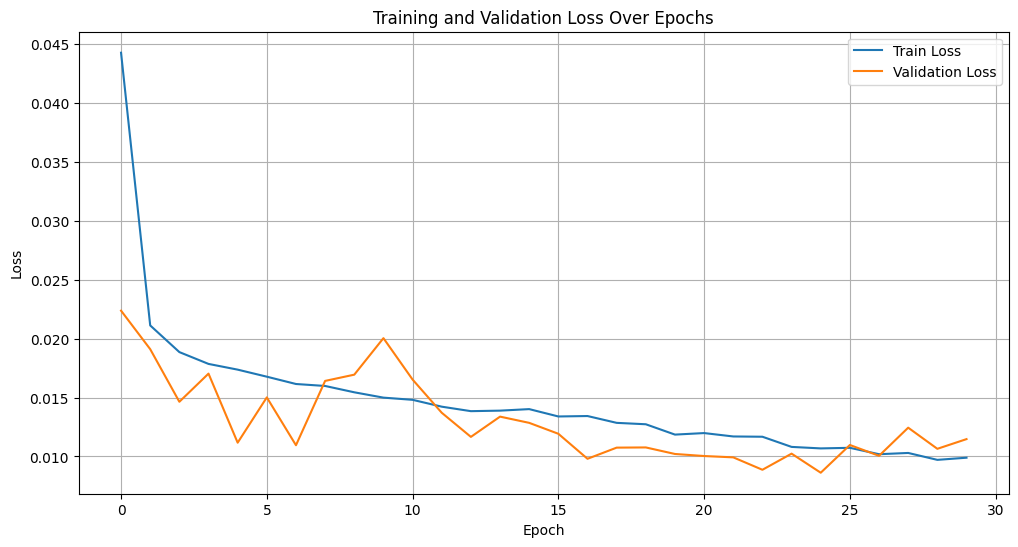

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 29
Test loss: 2.819
Test correlation: 0.887
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.006153263891714492


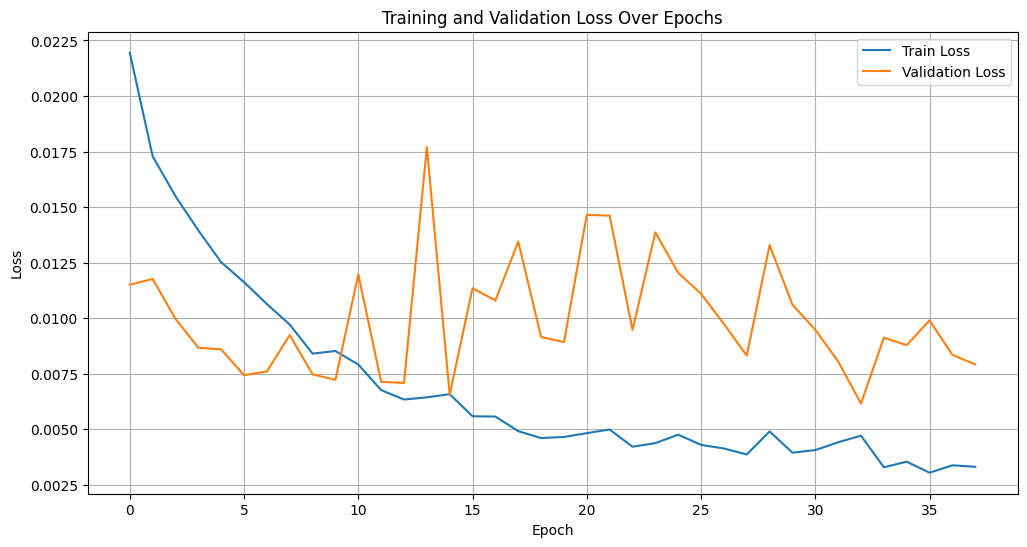

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 37
Test loss: 2.363
Test correlation: 0.912
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.0056556519703008235


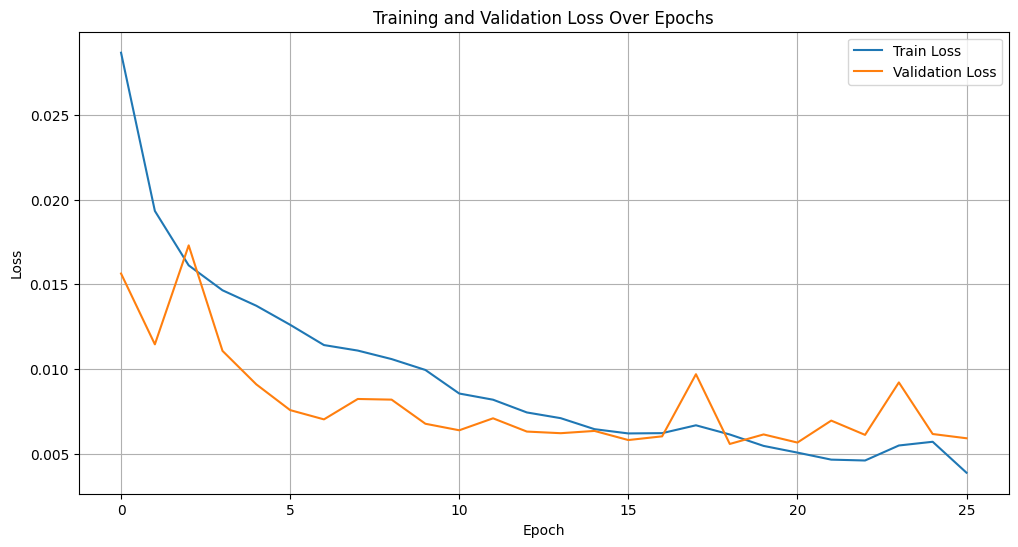

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 25
Test loss: 2.001
Test correlation: 0.904
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.004544097348116338


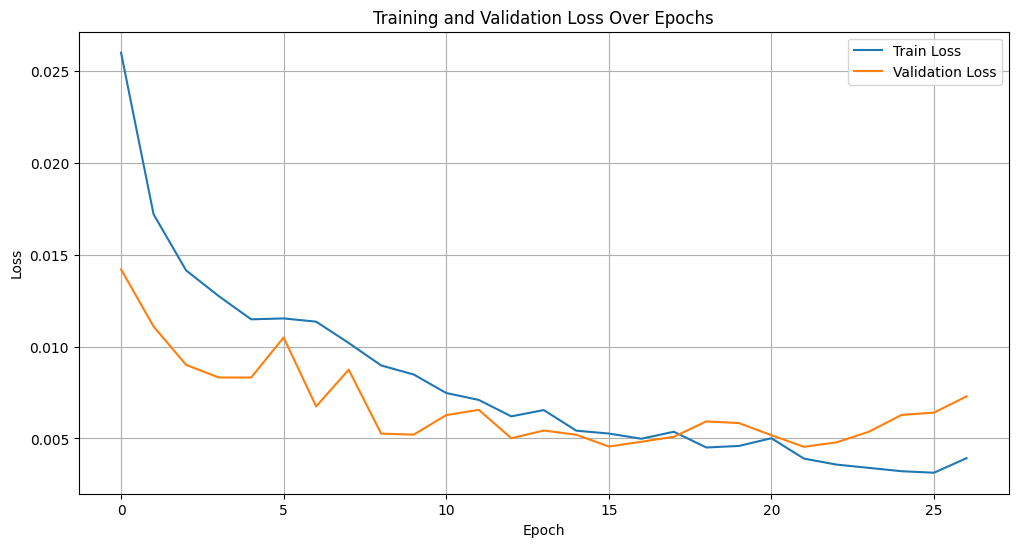

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 26
Test loss: 1.769
Test correlation: 0.941
random state: 2048
Best Test loss: 1.769
Best Test correlation: 0.941
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.004544097348116338
query numbers: 400
Number of epochs for best model: 21


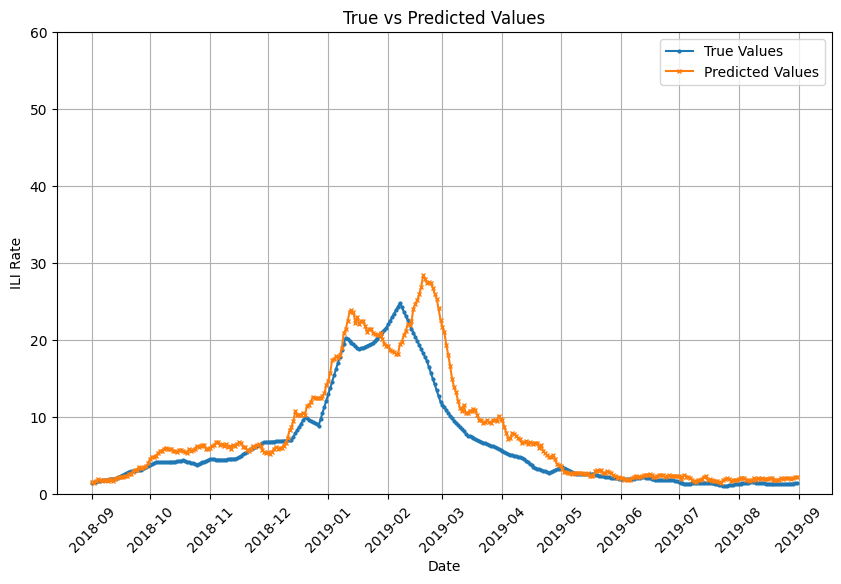

...............................................................
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.008981071005109698


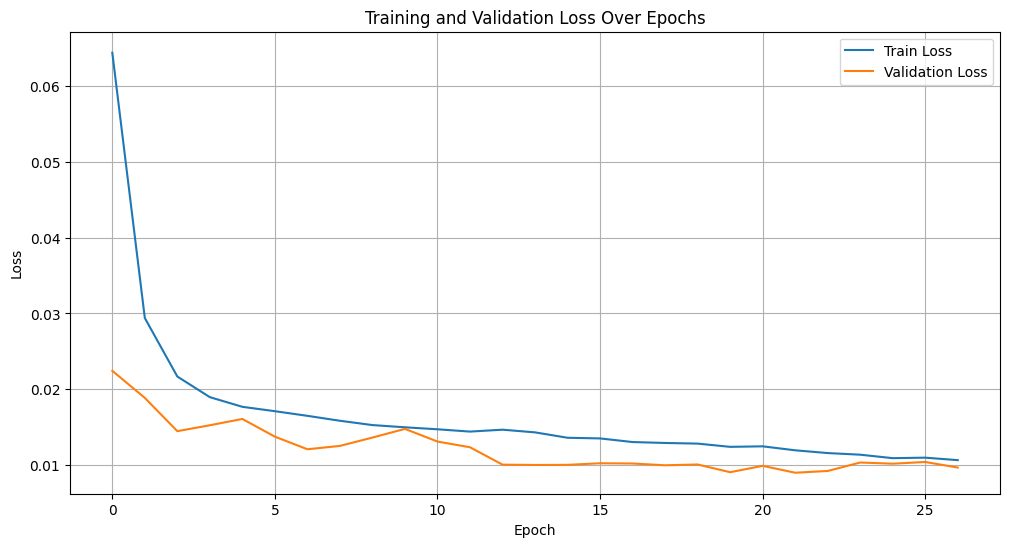

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 26
Test loss: 2.420
Test correlation: 0.902
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.00640989383516301


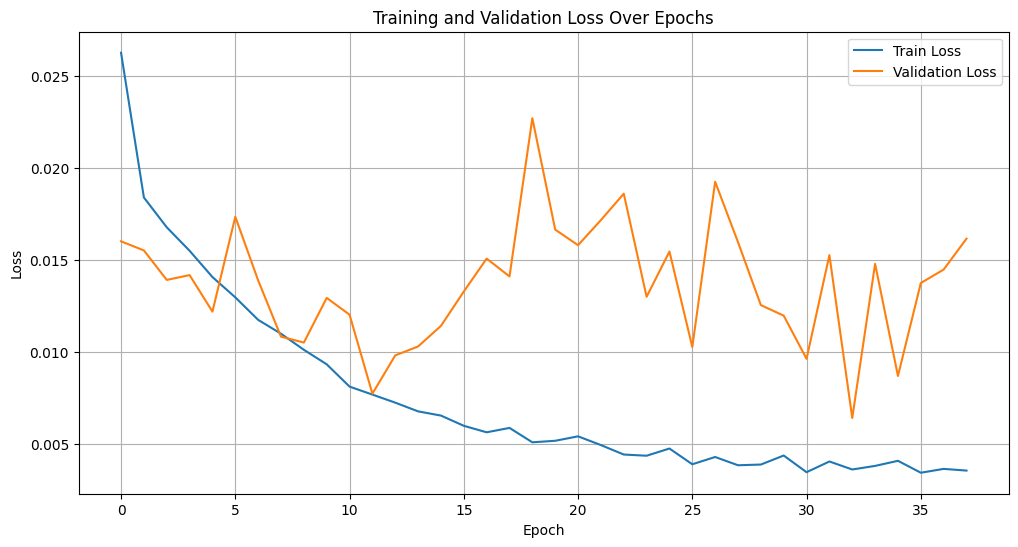

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 37
Test loss: 2.161
Test correlation: 0.917
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.005885212798602879


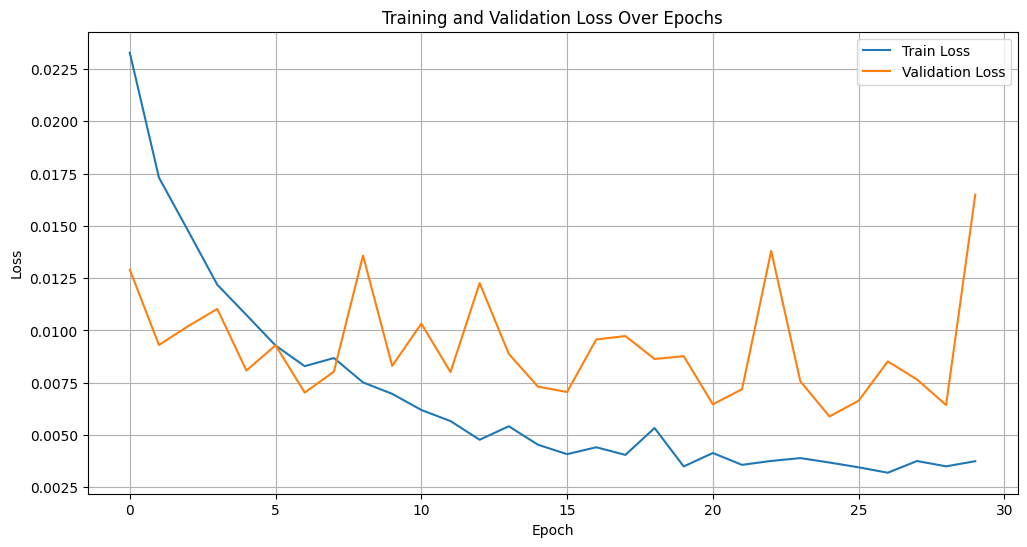

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 29
Test loss: 4.275
Test correlation: 0.915
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.004555551817507616


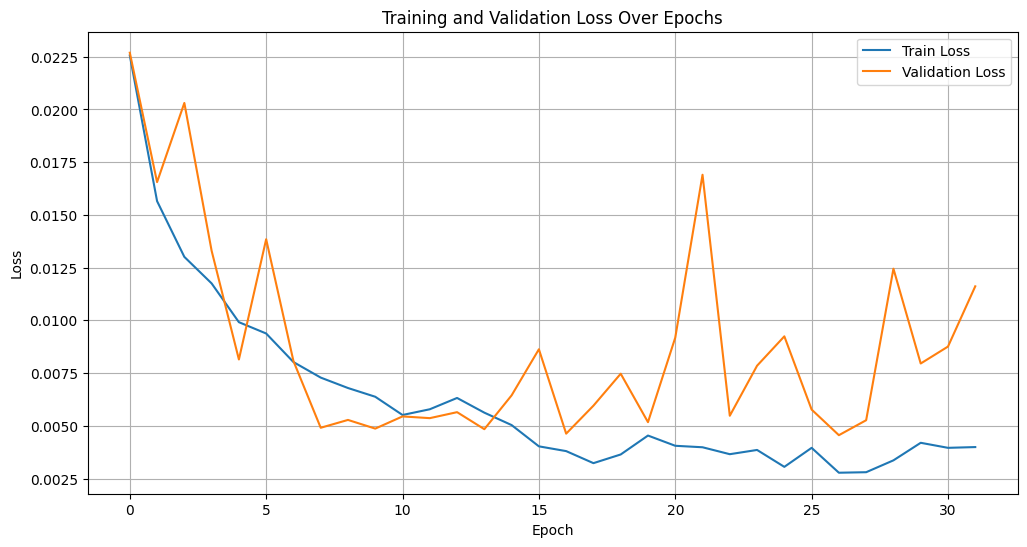

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 31
Test loss: 2.735
Test correlation: 0.950
random state: 4096
Best Test loss: 2.735
Best Test correlation: 0.950
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.004555551817507616
query numbers: 400
Number of epochs for best model: 26


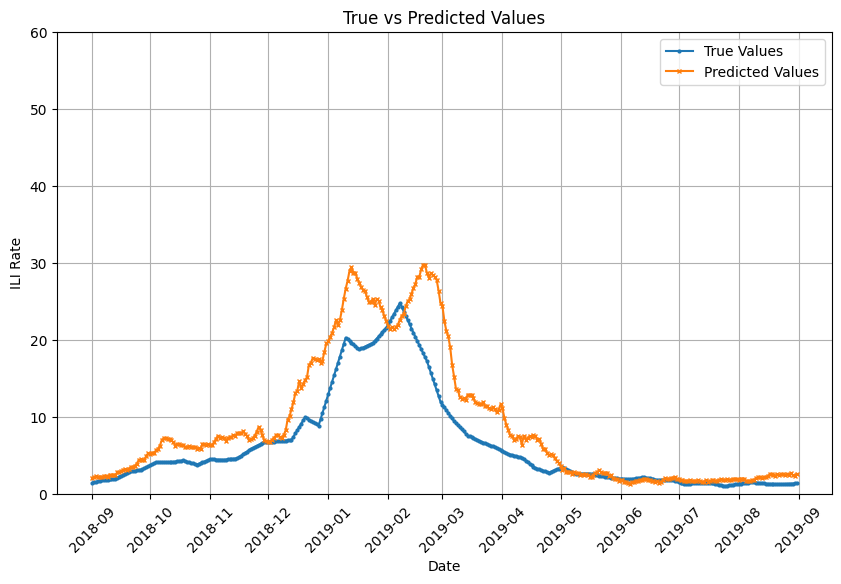

...............................................................
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.007448045595083386


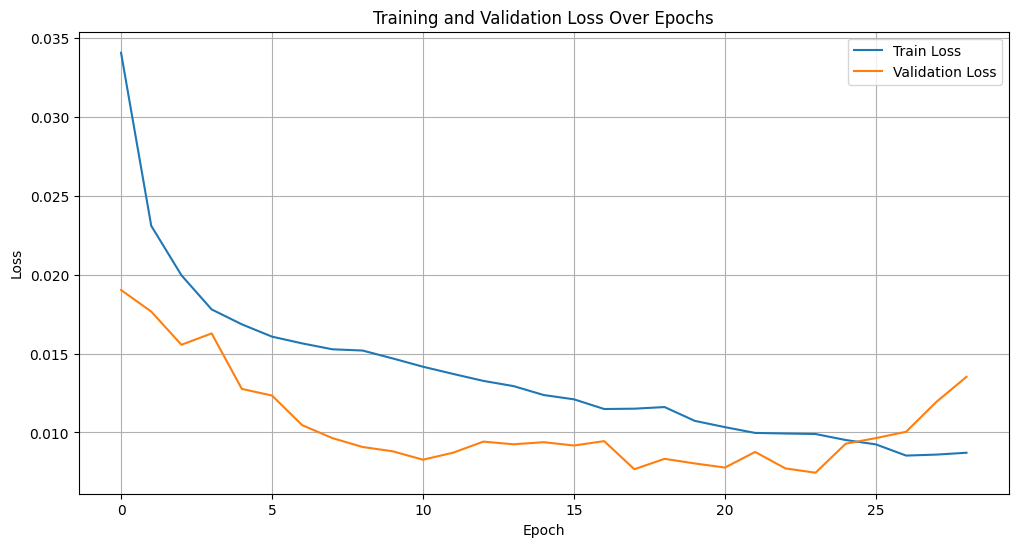

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 28
Test loss: 2.797
Test correlation: 0.895
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.005674880671514464


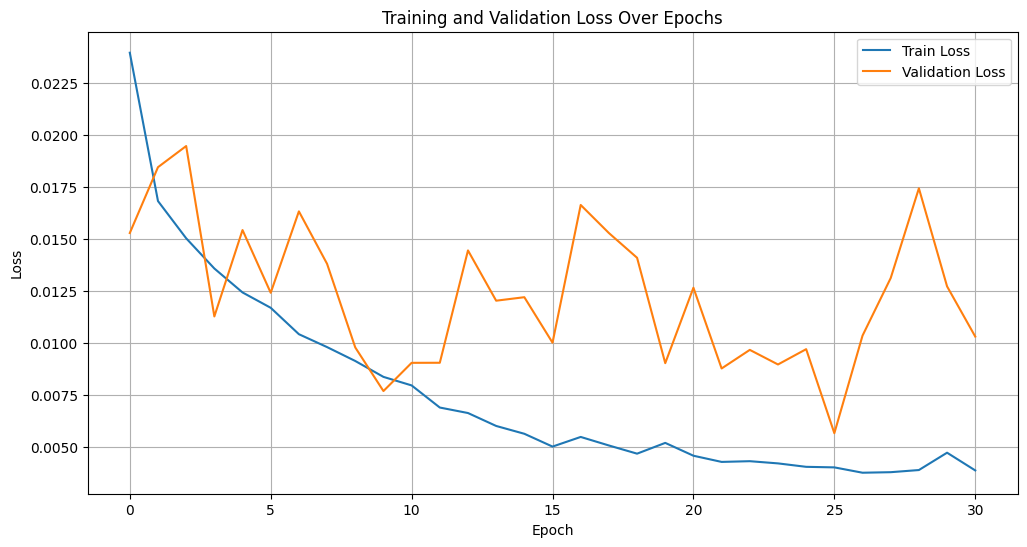

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 30
Test loss: 2.447
Test correlation: 0.899
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.006016193868293028


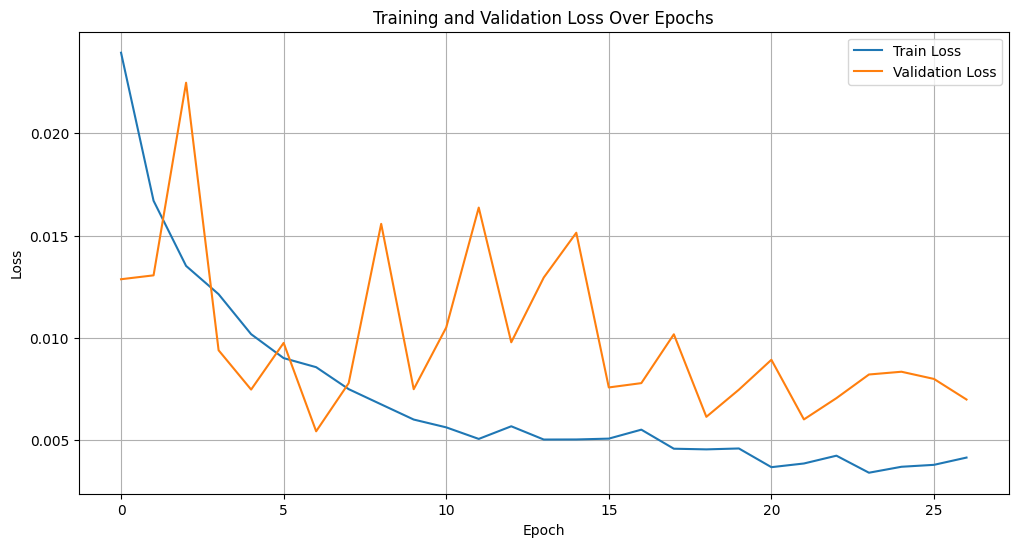

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 26
Test loss: 2.416
Test correlation: 0.910
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.004044964726615165


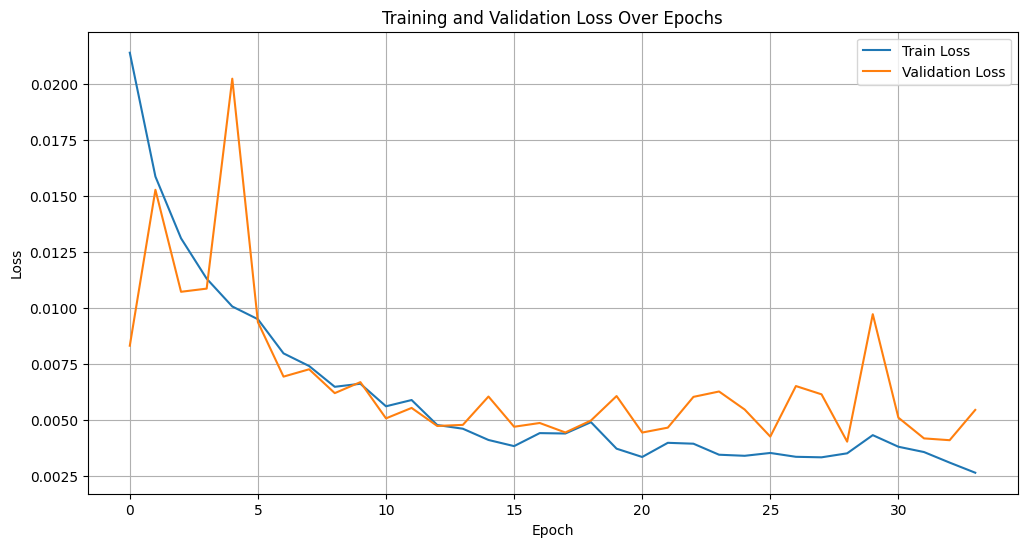

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 25}
Number of epochs for best model: 33
Test loss: 2.052
Test correlation: 0.941
random state: 8192
Best Test loss: 2.052
Best Test correlation: 0.941
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.004044964726615165
query numbers: 400
Number of epochs for best model: 28


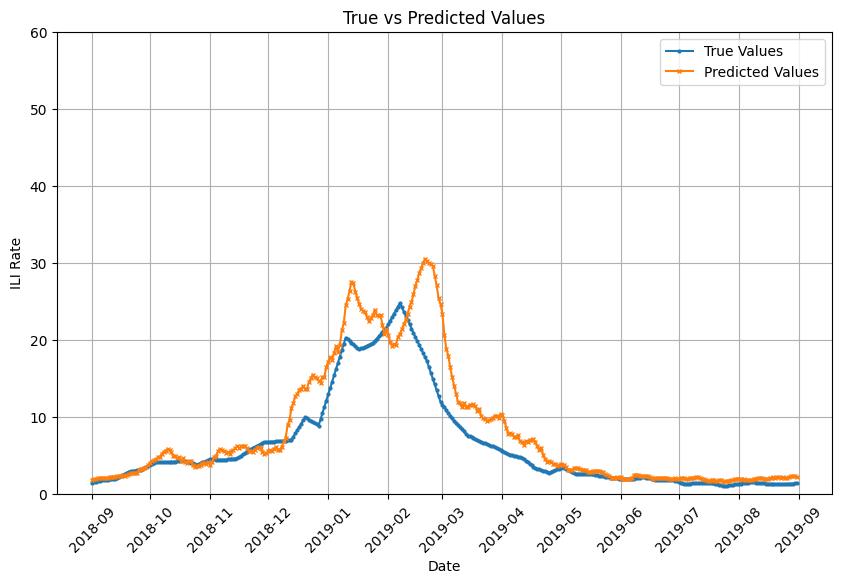

...............................................................
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.008716134005226195


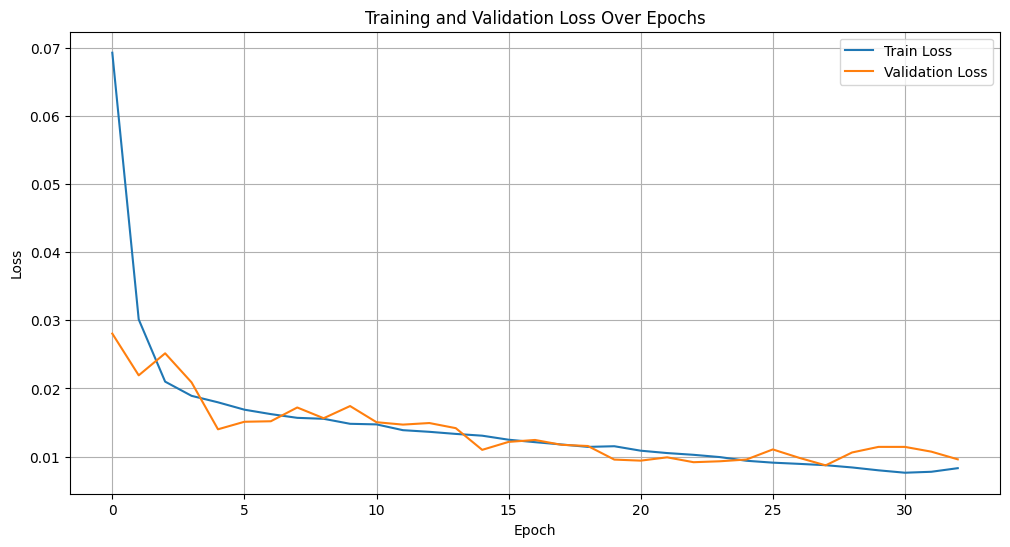

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 32
Test loss: 2.300
Test correlation: 0.896
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.00626216089585796


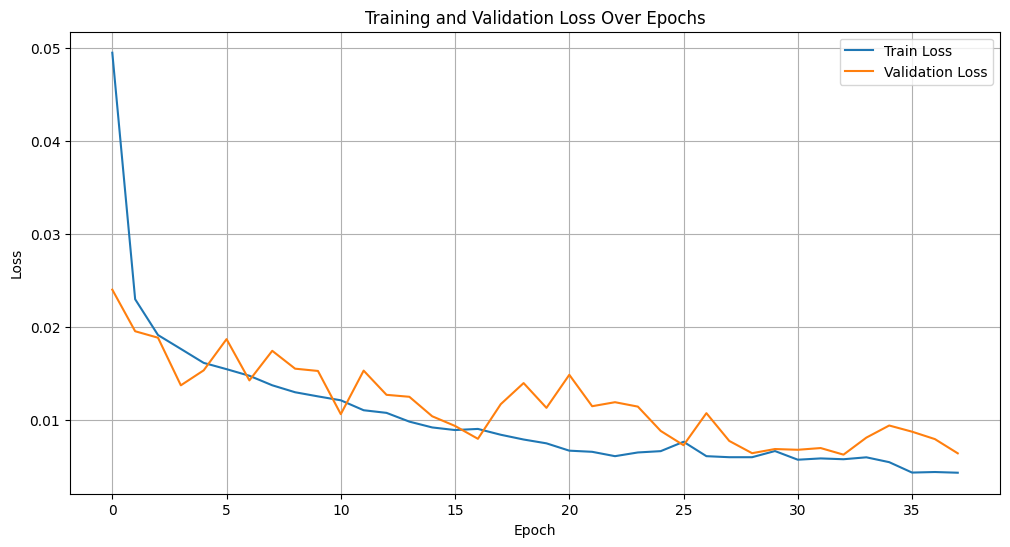

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 37
Test loss: 2.542
Test correlation: 0.859
Best parameters: {'batch_size': 14, 'lr': 1e-05, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.0060121907320405754


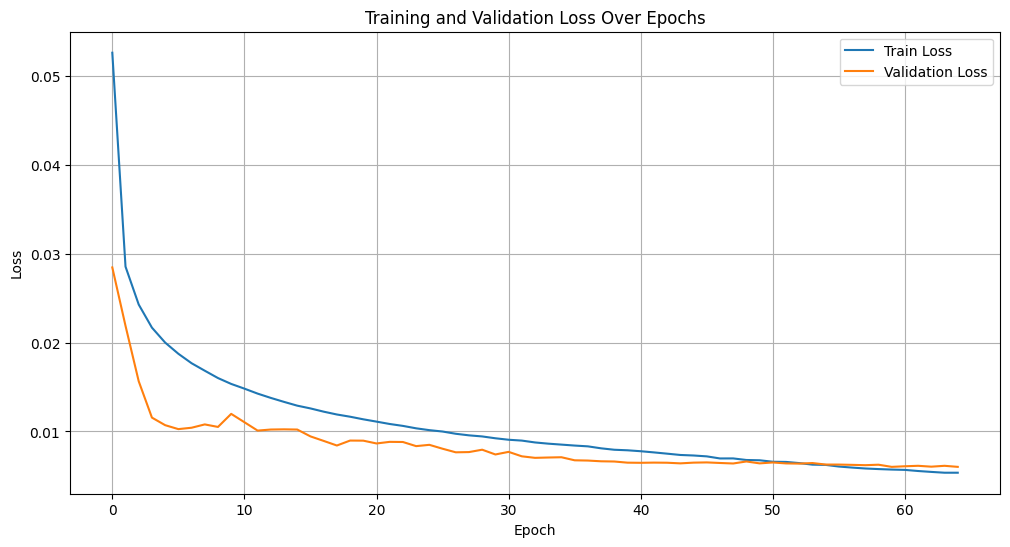

Best parameters: {'batch_size': 14, 'lr': 1e-05, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 64
Test loss: 1.905
Test correlation: 0.937
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.004659716322618935


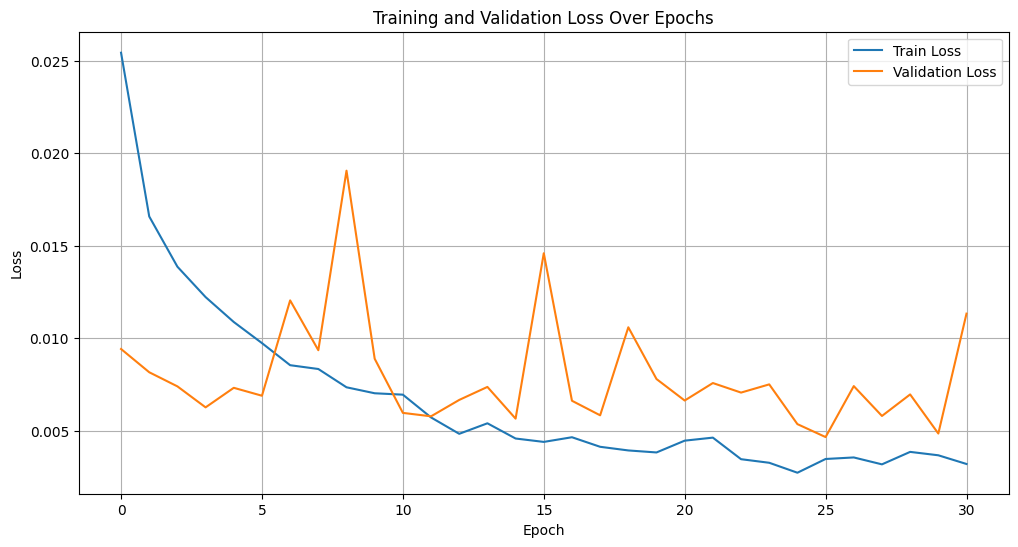

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 30
Test loss: 3.685
Test correlation: 0.939
random state: 16384
Best Test loss: 3.685
Best Test correlation: 0.939
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.004659716322618935
query numbers: 400
Number of epochs for best model: 25


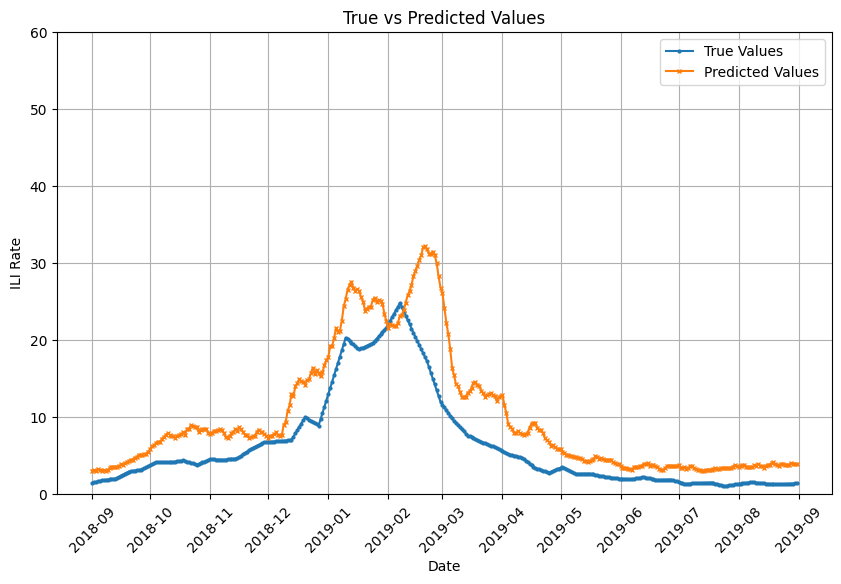

...............................................................
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.008273164508864284


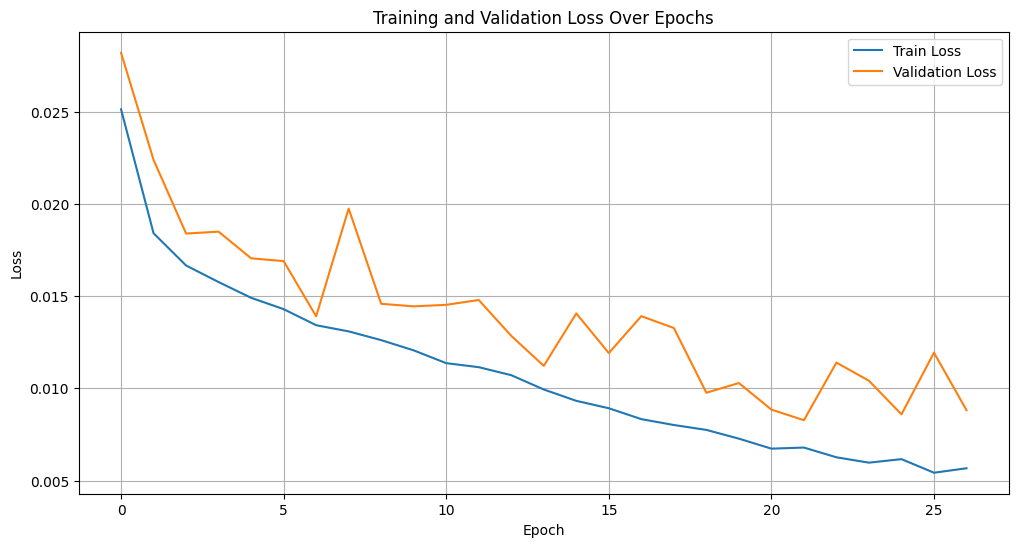

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 26
Test loss: 2.082
Test correlation: 0.905
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.0057907616054373124


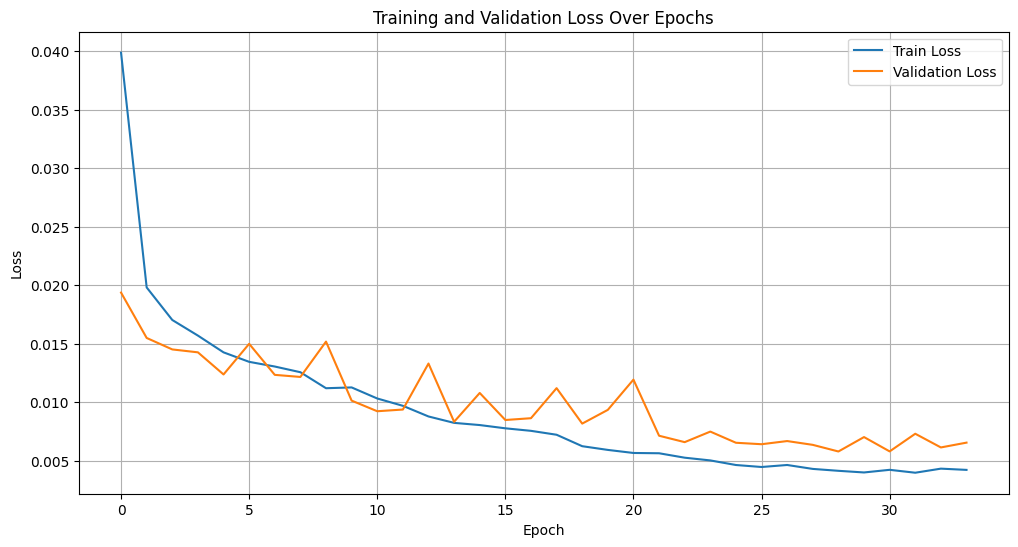

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 33
Test loss: 1.979
Test correlation: 0.849
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.0054462457774207


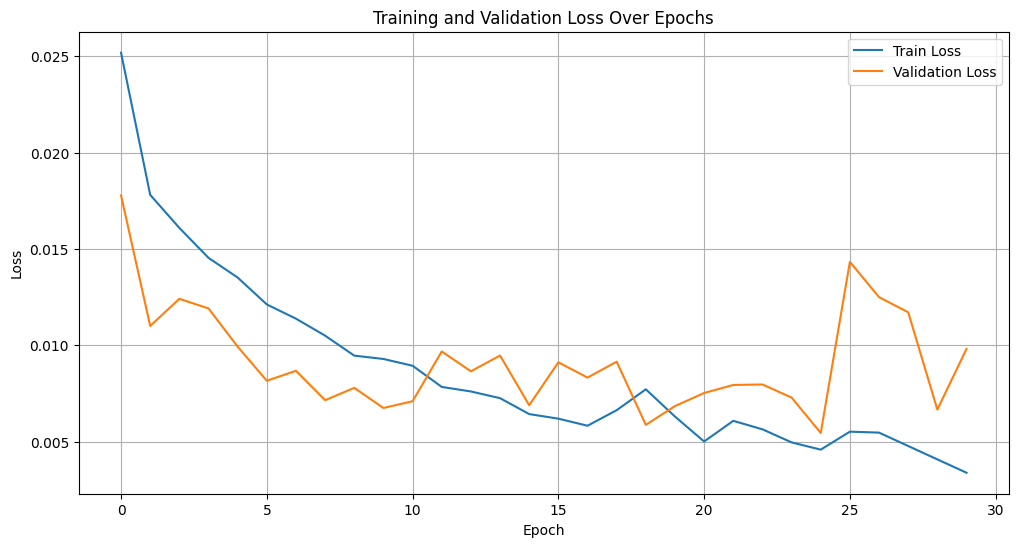

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 29
Test loss: 4.238
Test correlation: 0.928
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.004520012830783214


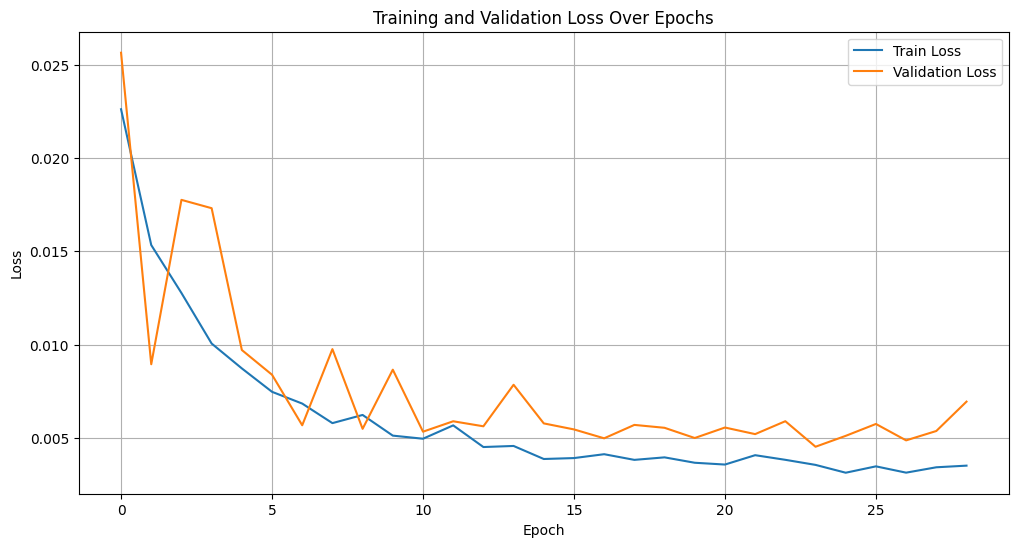

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 28
Test loss: 1.695
Test correlation: 0.945
random state: 15510
Best Test loss: 1.695
Best Test correlation: 0.945
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.004520012830783214
query numbers: 400
Number of epochs for best model: 23


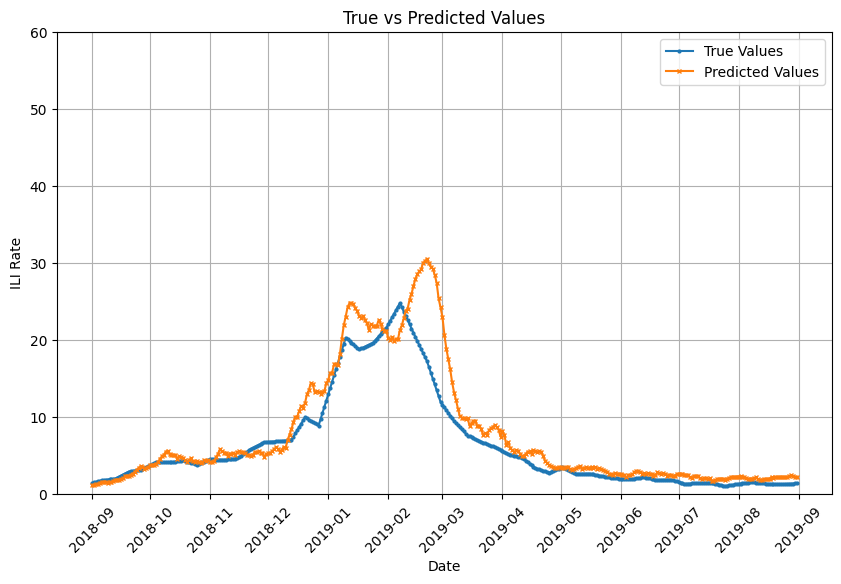

...............................................................
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.008782506354951434


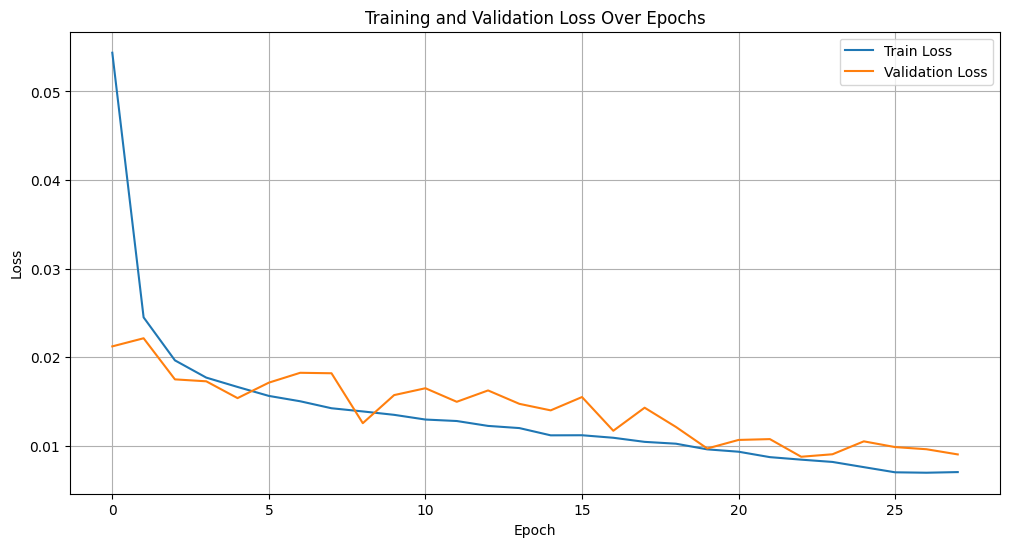

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 27
Test loss: 2.659
Test correlation: 0.891
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.006712707171183345


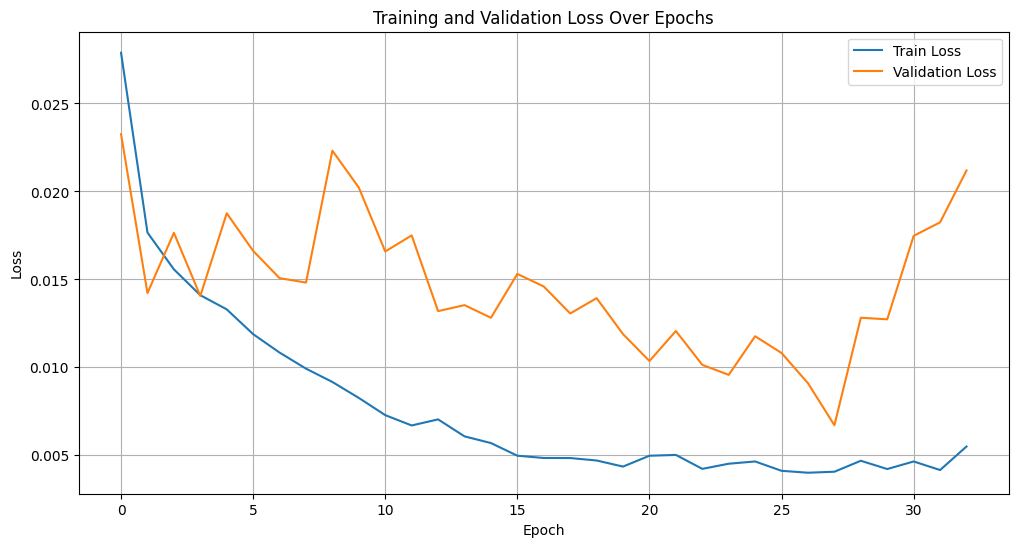

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 32
Test loss: 3.038
Test correlation: 0.896
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.005986055633651891


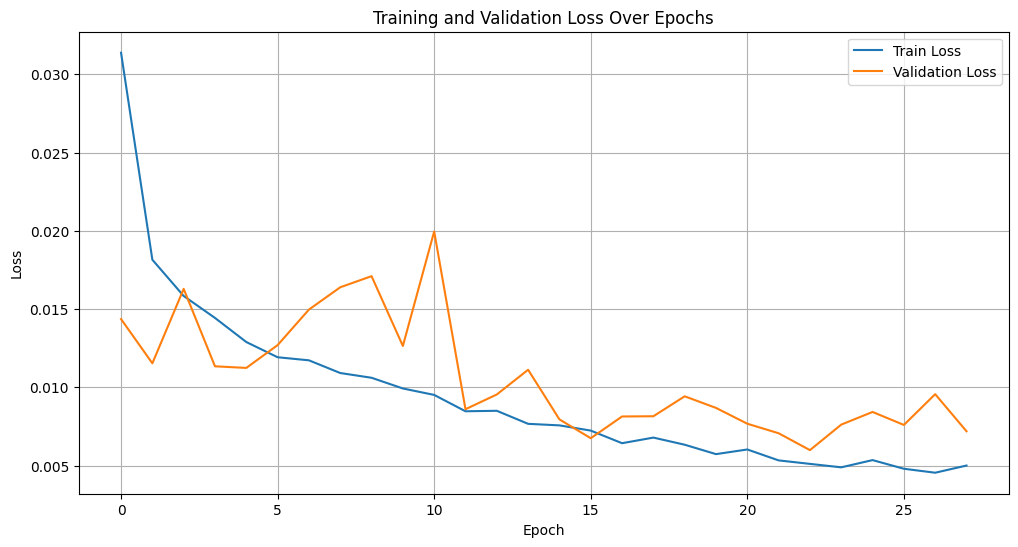

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Number of epochs for best model: 27
Test loss: 2.001
Test correlation: 0.891
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.004333618097007275


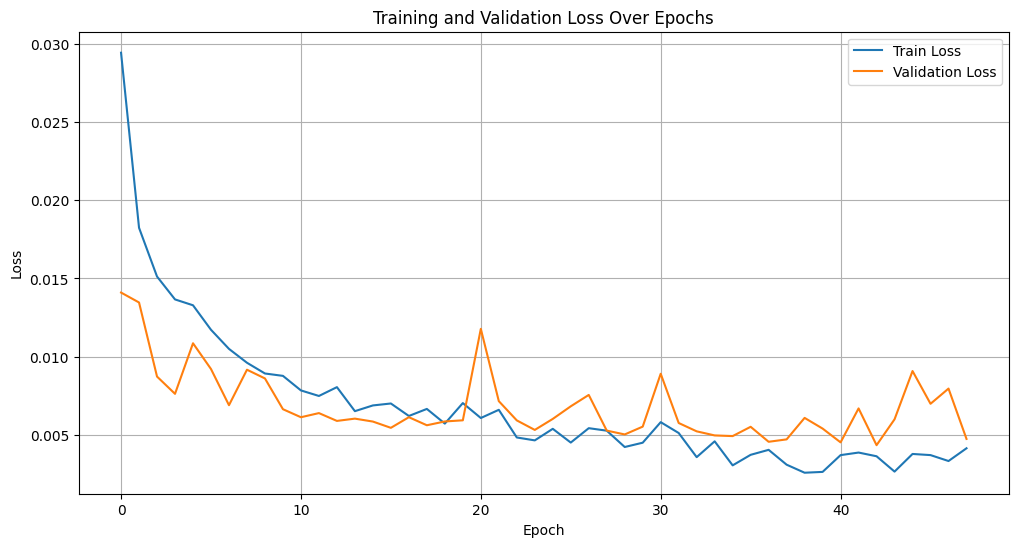

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Number of epochs for best model: 47
Test loss: 2.118
Test correlation: 0.941
random state: 1854
Best Test loss: 2.118
Best Test correlation: 0.941
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.004333618097007275
query numbers: 400
Number of epochs for best model: 42


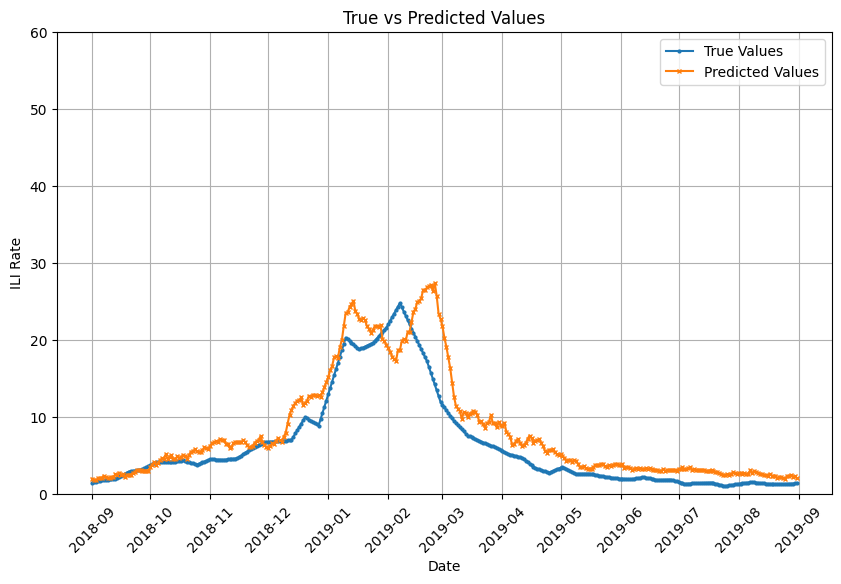

...............................................................
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.007716851275680321


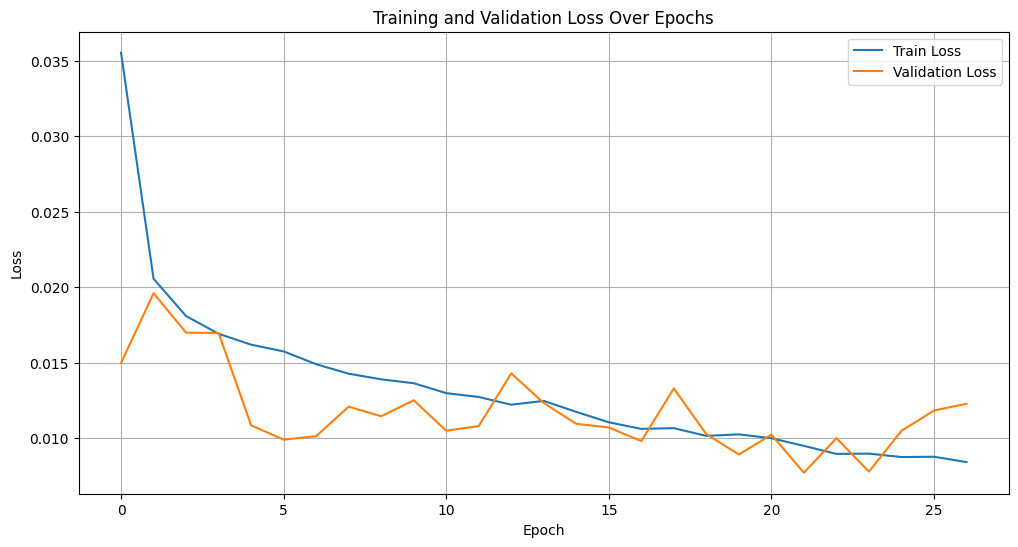

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 26
Test loss: 2.742
Test correlation: 0.895
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.005889988936749952


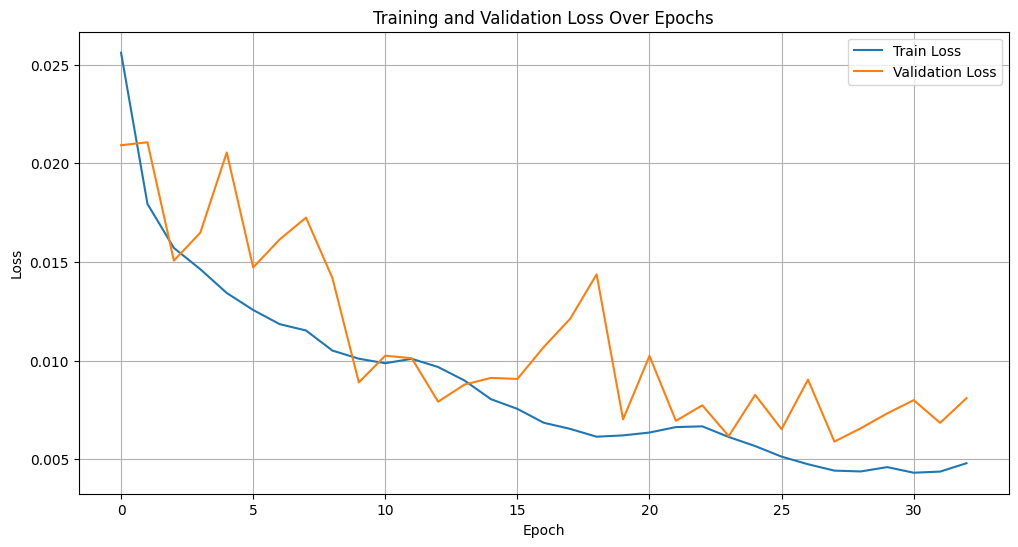

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 32
Test loss: 2.332
Test correlation: 0.906
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.0058412341001842704


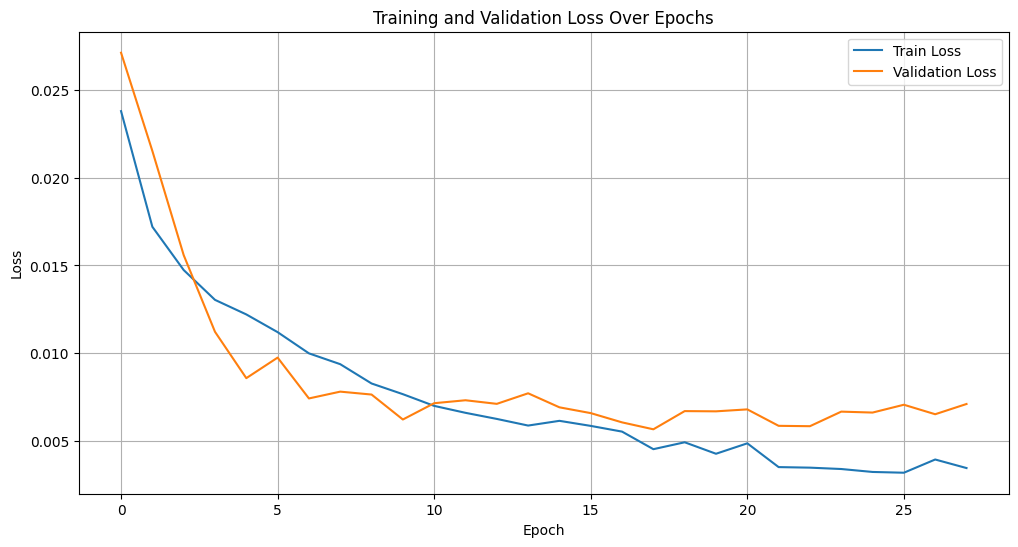

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Number of epochs for best model: 27
Test loss: 3.424
Test correlation: 0.904
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.00439615108189173


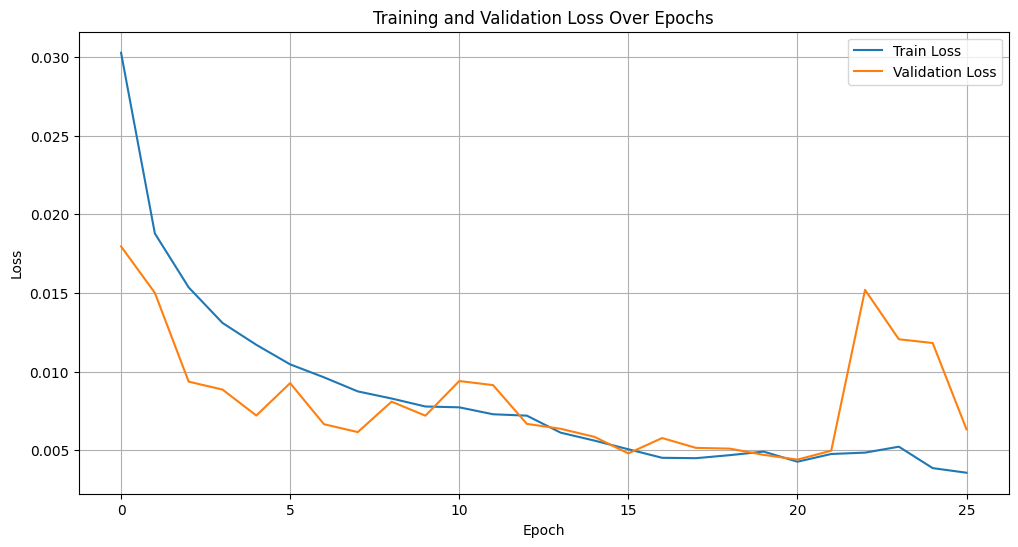

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 25
Test loss: 2.002
Test correlation: 0.938
random state: 18296
Best Test loss: 2.002
Best Test correlation: 0.938
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.00439615108189173
query numbers: 400
Number of epochs for best model: 20


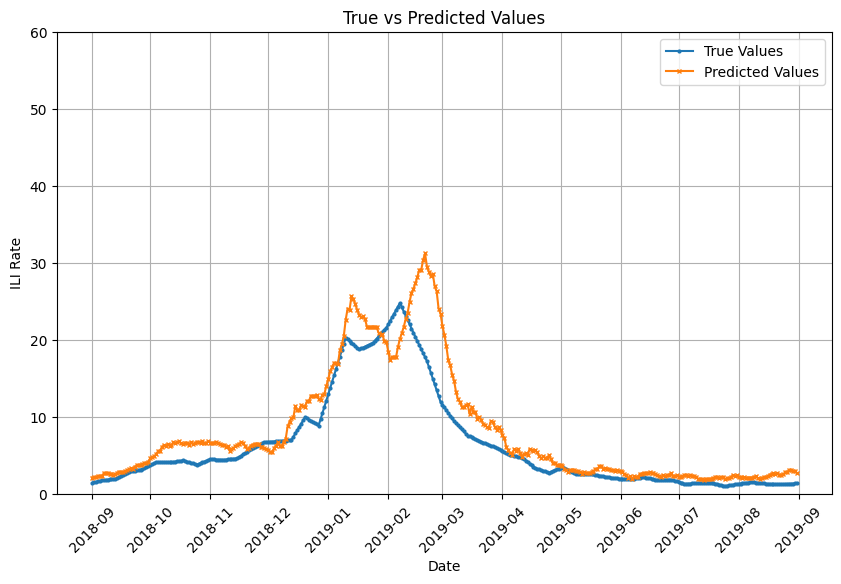

...............................................................
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.008108685092468346


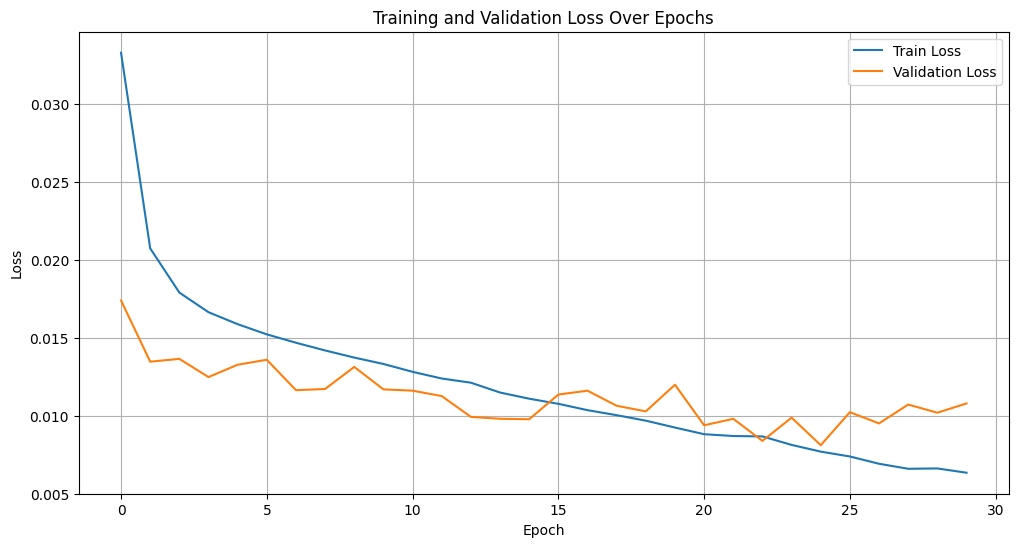

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 29
Test loss: 2.575
Test correlation: 0.888
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Best validation loss: 0.006034218589775264


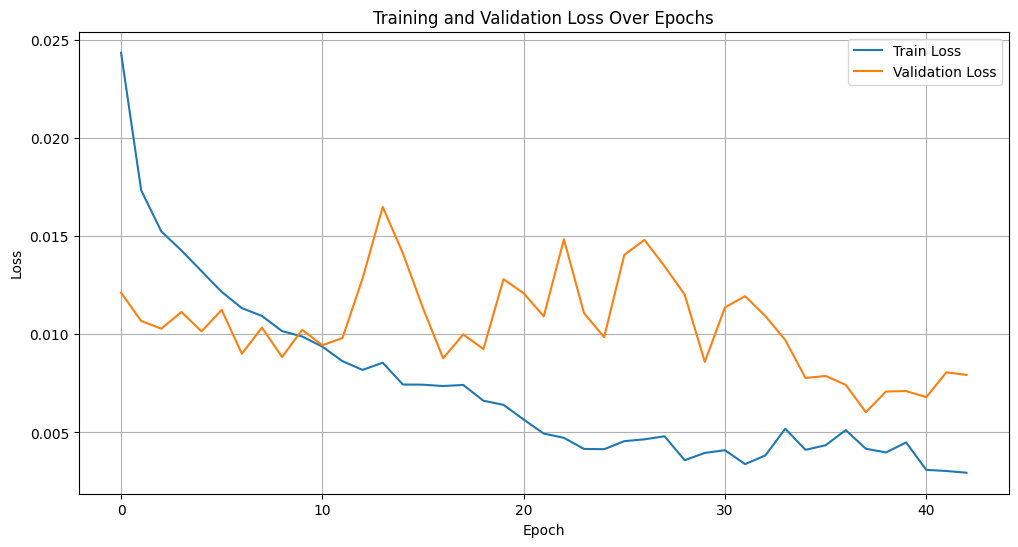

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 25}
Number of epochs for best model: 42
Test loss: 2.182
Test correlation: 0.901
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.005587744934018701


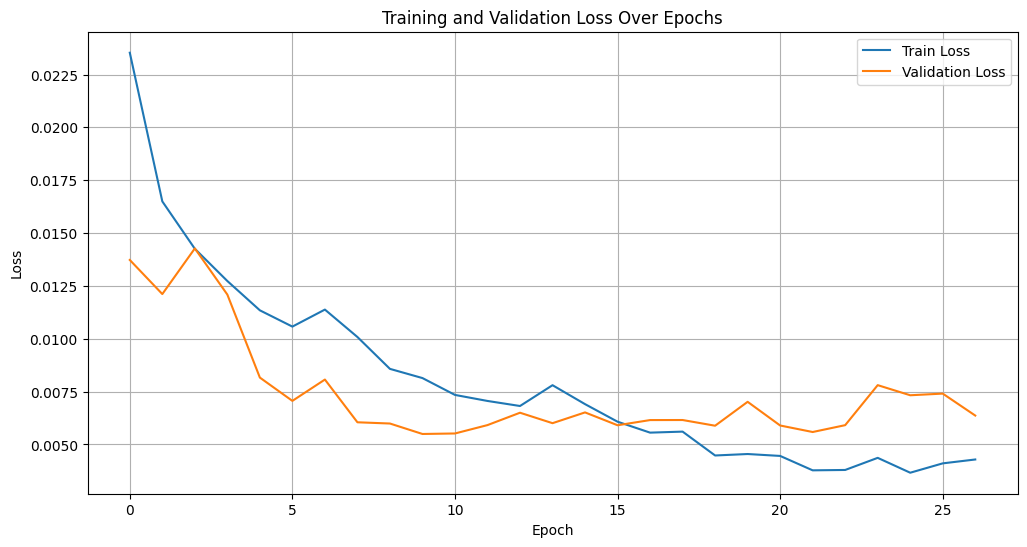

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 26
Test loss: 2.318
Test correlation: 0.915
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.00426160274738712


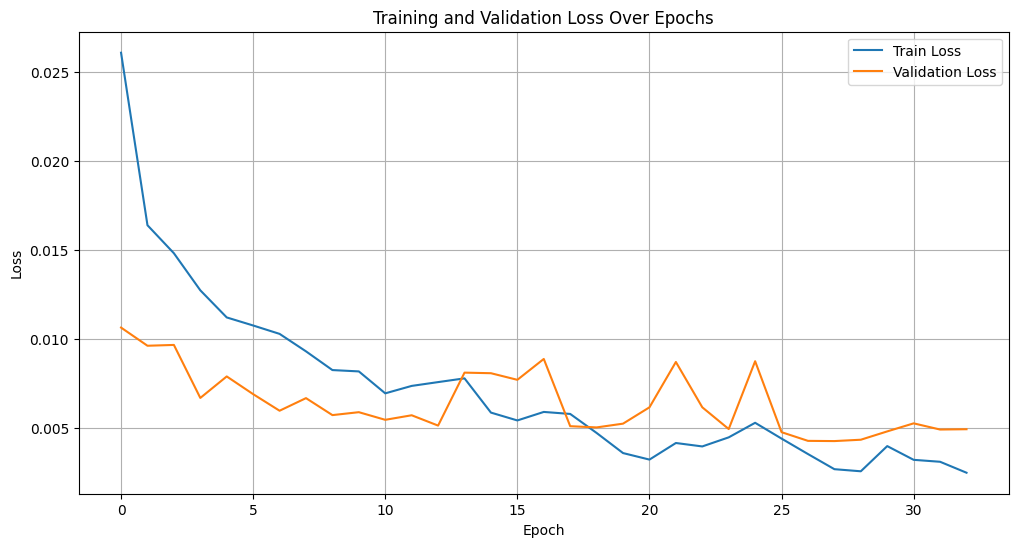

Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 32
Test loss: 2.397
Test correlation: 0.946
random state: 16652
Best Test loss: 2.397
Best Test correlation: 0.946
Best parameters: {'batch_size': 28, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.00426160274738712
query numbers: 400
Number of epochs for best model: 27


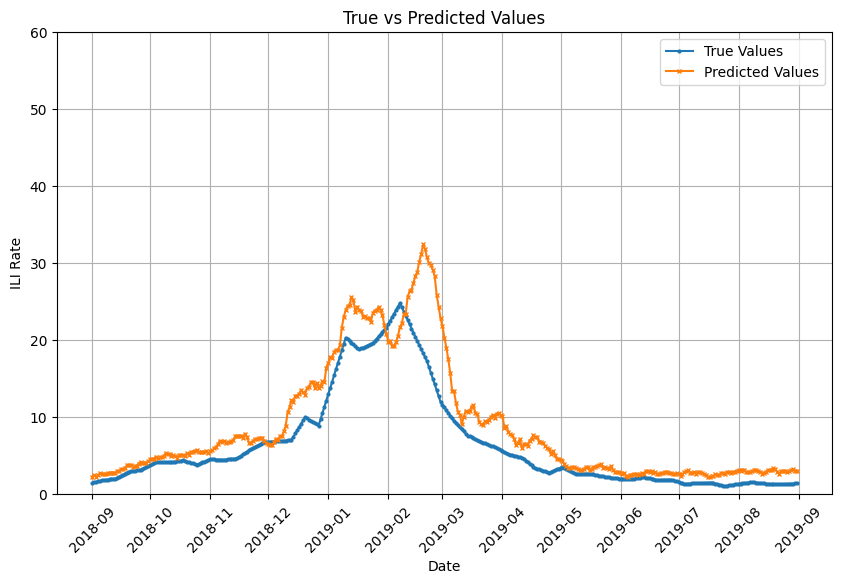

...............................................................
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.007566038926597685


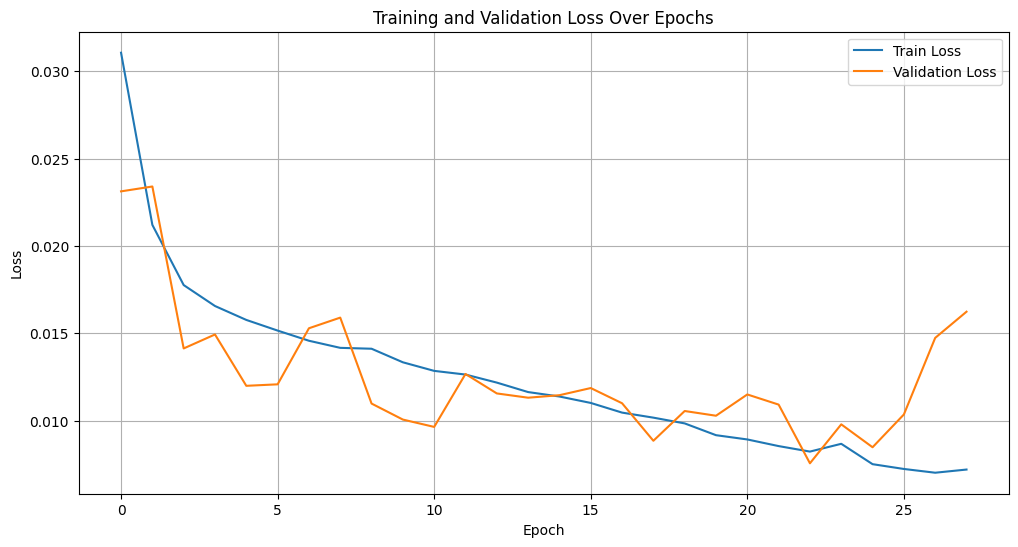

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 27
Test loss: 3.297
Test correlation: 0.930
Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Best validation loss: 0.005046274895513696


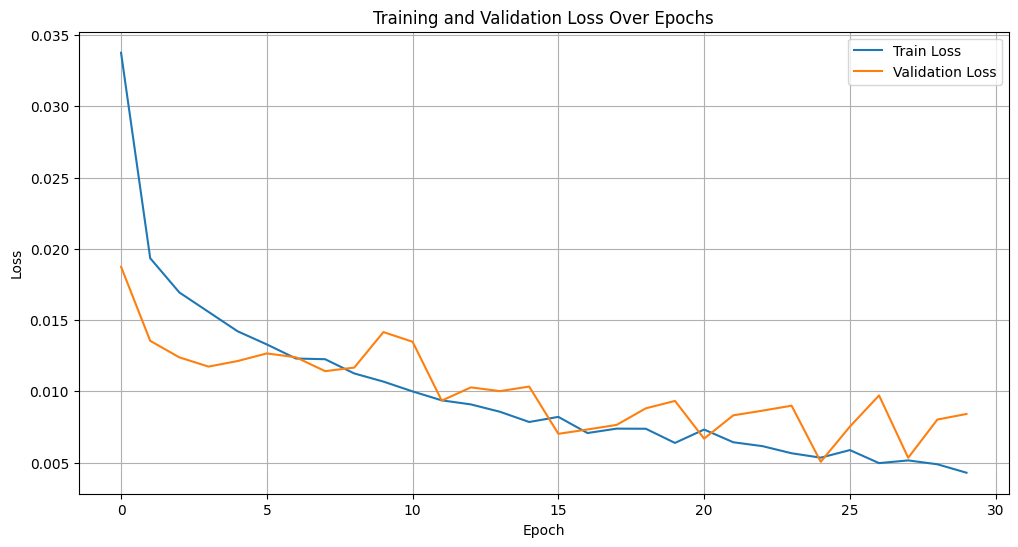

Best parameters: {'batch_size': 14, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 25, 'n_units3': 25}
Number of epochs for best model: 29
Test loss: 1.781
Test correlation: 0.904
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Best validation loss: 0.0055326984147541225


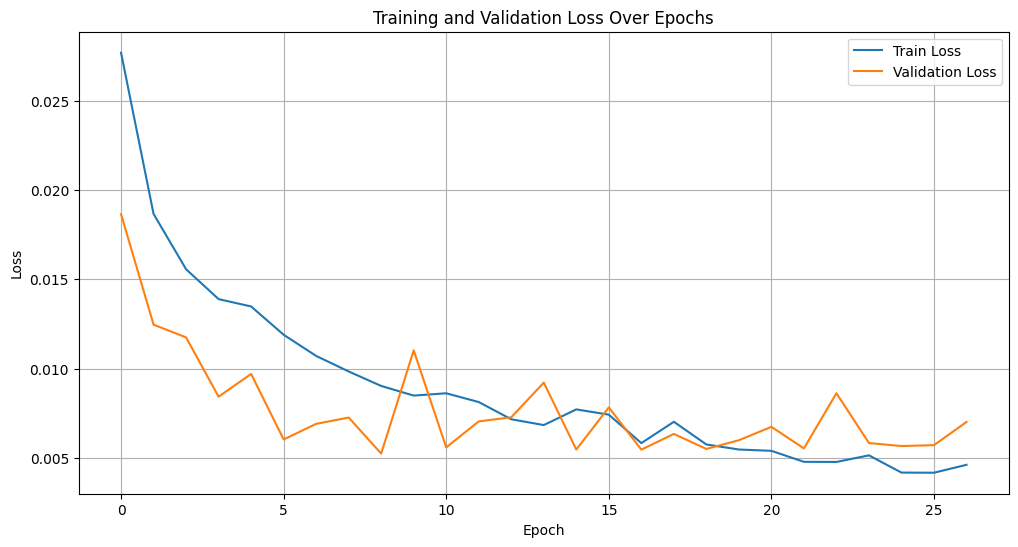

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 100, 'n_units2': 25, 'n_units3': 50}
Number of epochs for best model: 26
Test loss: 1.692
Test correlation: 0.923
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.003890683496138081


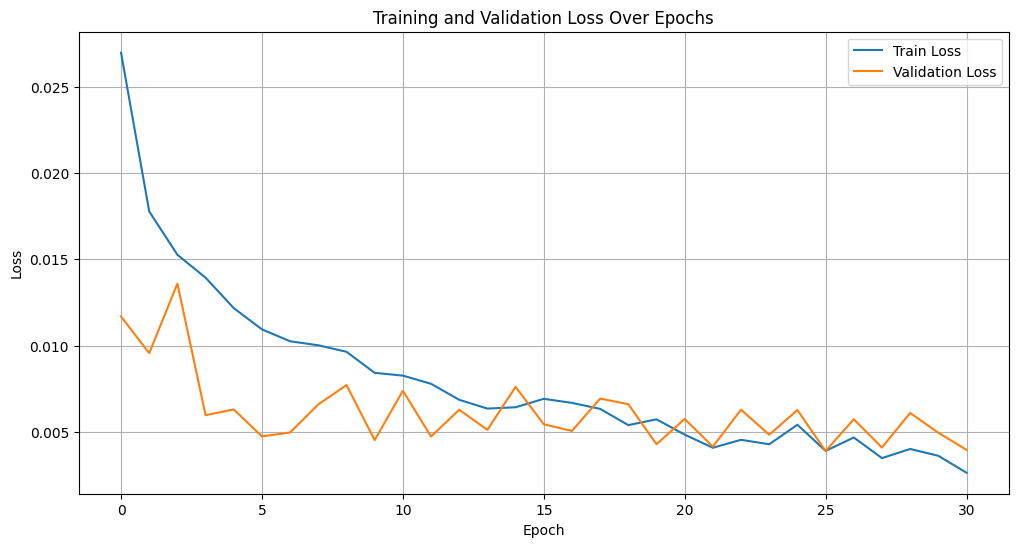

Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Number of epochs for best model: 30
Test loss: 1.643
Test correlation: 0.940
random state: 11085
Best Test loss: 1.643
Best Test correlation: 0.940
Best parameters: {'batch_size': 56, 'lr': 0.0001, 'n_units1': 50, 'n_units2': 50, 'n_units3': 50}
Best validation loss: 0.003890683496138081
query numbers: 400
Number of epochs for best model: 25


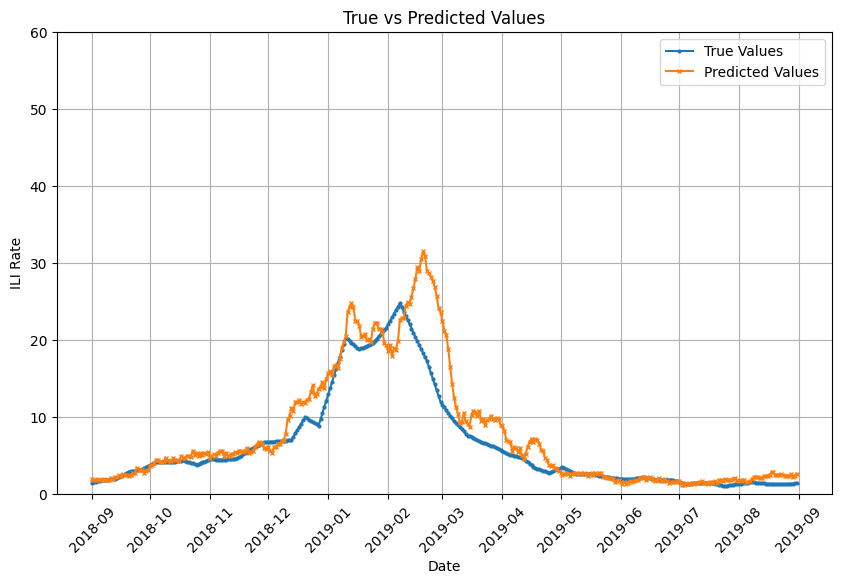

...............................................................


In [ ]:
random_seeds = [1024, 2048, 4096, 8192, 16384, 15510, 1854, 18296, 16652, 11085]

test_loss_all = []
test_correlation_all = []
all_predictions = []

# 创建并打开CSV文件，准备写入
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    # 原有的循环
    for rs in random_seeds:
        min_loss = 1000000
        tl = 0
        tcorr = 0
        params = {}
        quries_number = 0
        epoch_number = 0
        best_predicted_values = []
        for n in N:
            top_N_query_ids_corr = correlations_corr.abs().sort_values(ascending=False).head(n).index

            train0_data_scaled, validation_data_scaled, test_data_scaled, target_scaler = scale_data(top_N_query_ids_corr, test_data, train1_data, validation_data, train0_data)

            train0_X, train0_y = prepare_data(train0_data_scaled)
            validation_X, validation_y = prepare_data(validation_data_scaled)
            test_X, test_y = prepare_data(test_data_scaled)

            train0_y = train0_y.values.reshape(-1, 1)
            test_y = test_y.values.reshape(-1, 1)
            validation_y = validation_y.values.reshape(-1, 1)

            train0_X = train0_X.values
            test_X = test_X.values
            validation_X = validation_X.values

            val_loss, test_loss, correlation, best_params, y_pred, best_epoch, y_true = train_evaluate_model(rs, param_grid, train0_X, train0_y, validation_X, validation_y, test_X, test_y, target_scaler)

            if val_loss < min_loss:
                min_loss = val_loss
                tl = test_loss
                tcorr = correlation
                params = best_params
                best_predicted_values = y_pred
                quries_number = n
                epoch_number = best_epoch - 5

        test_loss_all.append(tl)
        test_correlation_all.append(tcorr)
        all_predictions.append(best_predicted_values)

        # 写入当前结果到CSV文件
        '''
        ['test_season', 'input_size', 'random_state', 'best_validation_loss',
        'best_test_loss', 'best_test_correlation', 'best_parameters', 'query_numbers', 'number_of_epochs']
        '''
        writer.writerow(['18-19', '14', rs, min_loss, tl, tcorr, str(params), quries_number, epoch_number])

        print(f"random state: {rs}")
        print("Best Test loss: {:.3f}".format(tl))
        print("Best Test correlation: {:.3f}".format(tcorr))
        print(f"Best parameters: {params}")
        print(f"Best validation loss: {min_loss}")
        print(f"query numbers: {quries_number}")
        print(f"Number of epochs for best model: {epoch_number}")
        plot_results(rs, y_true, best_predicted_values)
        print("...............................................................")


In [ ]:
# # Convert all_predictions to numpy array
# all_predictions = np.array(all_predictions)

# # Calculate confidence intervals
# mean_prediction = np.mean(all_predictions, axis=0)
# conf_int_50 = np.percentile(all_predictions, [25, 75], axis=0)
# conf_int_90 = np.percentile(all_predictions, [5, 95], axis=0)

# # Plot results with confidence intervals
# dates = pd.date_range(start='2018-09-01', end='2019-08-31', freq='D')

# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot confidence intervals
# ax.fill_between(dates, conf_int_90[0], conf_int_90[1], color='lightblue', alpha=0.4, label='90% Confidence Interval')
# ax.fill_between(dates, conf_int_50[0], conf_int_50[1], color='blue', alpha=0.6, label='50% Confidence Interval')

# # Plot mean prediction
# ax.plot(dates, mean_prediction, color='blue', label='Mean Prediction')

# # Plot actual values
# ax.plot(dates, y_true, color='black', label='Actual ILI Rate')

# ax.set_xlabel('Date')
# ax.set_ylabel('ILI Rate %')
# ax.set_title('ILI Rate Predictions with Confidence Intervals')
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# ax.set_ylim(0, 60)
# plt.xticks(rotation=45)
# ax.legend()
# ax.grid(True)

# plt.savefig("/content/drive/My Drive/project/results/plot/18-19/Nowcasting/Strategy4/prediction_confidence_intervals.pdf")
# plt.show()